###Connect to Drive

In [2]:
# # Import PyDrive and associated libraries.
# # This only needs to be done once per notebook.
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)


In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Installs and Import

In [24]:
# !pip install -q keras
# !pip install --upgrade opencv-python
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-gpu
# !pip install --upgrade matplotlib
# !pip install --upgrade numpy
# !pip install --upgrade pydot
# !pip install --upgrade tqdm
!pip install --upgrade category_encoders
!pip install --upgrade rotation-forest
!pip install --upgrade scikit_posthocs
# !pip install https://github.com/AmazaspShumik/sklearn_bayes/archive/master.zip
# !pip install --upgrade https://github.com/AmazaspShumik/sklearn_bayes/archive/master.zip


Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.2.2)
Requirement already up-to-date: rotation-forest in /usr/local/lib/python3.6/dist-packages (0.4)
Requirement already up-to-date: scikit_posthocs in /usr/local/lib/python3.6/dist-packages (0.6.5)


In [302]:

# Helper libraries
import math
import numpy as np
import pandas as pd
import cv2
import csv


import os, shutil,io
import keras
from keras import layers
from keras import models
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.metrics import *
from sklearn.multiclass import OneVsRestClassifier
import rotation_forest as af
from skimage.transform import resize
from xgboost import XGBClassifier
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from numpy import genfromtxt
import inspect
import tensorflow as tf
import xgboost as xgb
import argparse
# from skbayes.mixture_models import VBBMM
from scipy.special import logsumexp
from scipy.stats import friedmanchisquare
from sklearn.metrics import auc as auc_score
import scikit_posthocs as scl_hoc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tf verbose logs

try:
	from time import perf_counter
except:
	from time import time
	perf_counter = time

# Improve progress bar display
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


import PIL
import pydot
import warnings
import category_encoders as ce
from google.colab import output
warnings.filterwarnings('ignore')

##check gpu connection and print tf version

In [26]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.3.0


##Paths

In [27]:
project_dir_path = "/content/drive/Shared drives/Machine_Learning_Project/"
data_path = "/content/drive/Shared drives/Machine_Learning_Project/Classification_datasets/classification_datasets"
labeled_data_path = "/content/drive/Shared drives/Machine_Learning_Project/Classification_datasets/labeled_classification_datasets"
results_path = "/content/drive/Shared drives/Machine_Learning_Project/Results"

FINISH_SOUNDS = lambda: output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/1/1d/Lala_la_lala_la_lala_la_lala.ogg").play()')

#Models

##Parameters

In [28]:
seed=1
n_splits = 10
smoothing = 0.6
random_state = 42
test_size = 0.4
EPSILON = 1e-8
verbose = 2
fill_mode='nearest'
class_mode='categorical'

#Arranged Forest

##Distributor

###Random Distribute

    Randomly distribute features into trees, without replacement
    num_feature: number of features
    num_trees: number of trees
    feature_per_tree: number of features in one tree
    distributions: distributions already determined
    seed: random seed
    return: the groups of features
        output example [[0,1] , [1,2]]
        feature id is from 0 to (num_feature-1)

In [29]:
def random_distribute(num_feature, num_trees, feature_per_tree, distributions, seed):
  print("using random_distribute")
  # random distribution is quick, but not necessarily gives low similarity
  np.random.seed(seed)

  m = num_feature
  k = feature_per_tree

  tree_to_build = num_trees - len(distributions)

  # identify all features with array 0,1,2,...,num_feature-1

  # in set type, used internally
  all_distribution_set = []

  for i in distributions:
      all_distribution_set.append(set(i))

  final_distribution = []

  # randomly pick num_feature from all_feature
  # if it is in the set, try once more
  while len(all_distribution_set) < tree_to_build:

      random_set = set(np.random.choice(m, k, replace=False))

      if random_set not in all_distribution_set:
          all_distribution_set.append(random_set)
          if len(all_distribution_set) == tree_to_build:
              break

  for i in all_distribution_set:
      final_distribution.append(list(i))

  return final_distribution


###Bootstrap Samples

```
  Randomly distribute samples into trees, with replacement
  num_trees: number of trees
  data_x: feature values
  data_y: labels
  seed: random seed
  return: the groups of samples of feature values and labels
      labels at last column
      output example [[0,1] , [1,2]]
```

In [30]:
def bootstrap_samples(num_trees, data_x, data_y, seed=1):
  print("using bootstrap_samples")

  np.random.seed(seed)
  # np.random.choice
  # get sample row numbers
  num_instances = len(data_x)

  row_sets = []

  while len(row_sets) < num_trees:

      random_set = np.random.choice(num_instances, num_instances, replace=True)
      row_sets.append(random_set)

  # return num_trees sets of x and y

  boot_x = []
  boot_y = []

  for i in row_sets:
    # print(i)
    # print('datax - {}'.format(data_x))
    # print('datay - {}'.format(data_y))
    
    # print('datax[i] - {}'.format(data_x[i]))
    # print('datay[i] - {}'.format(data_y[i]))
    boot_x.append(data_x[i])
    boot_y.append(data_y[i])

  return boot_x, boot_y

###Build Feature Matrix



```
  Build a feature matrix
  m must be k*k
  k = p
  num_feature: number of features
  feature_per_tree: number of features in one tree
  return: k*k feature matrix A
      output example [[0,1] , [2,3]]
      feature id is from 0 to (num_feature-1)
```



In [31]:
def build_feature_matrix(num_feature, feature_per_tree):
  print("using build_feature_matrix")
  
  m = num_feature
  k = feature_per_tree

  element_count = 0

  all_rows = []

  current_row = []

  for i in range(m):

      current_row.append(i)

      element_count += 1

      if element_count == k:
          all_rows.append(current_row)
          current_row = []
          element_count = 0

  feature_matrix = np.array(all_rows)

  return feature_matrix

###Build Plus Feature Matrix



```
Build a feature matrix
  m must be k*k
  k + 1 = p
  e.g., build_plus_feature_matrix(25, 5)
  num_feature: number of features
  feature_per_tree: number of features in one tree
  return: (k+1)*(k+1) feature matrix A+
      output example [[0,1] , [2,3]]
      feature id is from 0 to (num_feature-1)
      note: last row and column do not represent features
```



In [42]:
def build_plus_feature_matrix(num_feature, feature_per_tree):
  print("using build_plus_feature_matrix")
  
  m = num_feature
  k = feature_per_tree

  element_count = 0

  all_rows = []

  current_row = []

  for i in range(m):

      current_row.append(i)

      element_count += 1

      if element_count == k:

          # for last column, item is 0

          current_row.append(0)

          all_rows.append(current_row)

          current_row = []

          element_count = 0

  # add last row, all 0

  all_rows.append(np.zeros((k+1,), dtype=int))

  feature_matrix = np.array(all_rows)

  return feature_matrix

###Diagonal Distribute



```
  Diagonal distribution algorithm (DDA)
  for k = p
  feature_per_tree: number of features in one tree, k
  feature_matrix: k*k feature matrix from 0 to m-1, A
  return: the k family of features
      output example [[0,1] , [1,2]]
      feature id is from 0 to (num_feature-1)
```



In [43]:
def diagonal_distribute(feature_per_tree, feature_matrix):
  print("using diagonal_distribute")
  k = feature_per_tree
  A = feature_matrix

  # k family subset to return, F
  k_family_F = []

  F1 = []

  for j in range(k):
      F1.append(list(A[j]))

  k_family_F = k_family_F + F1

  F2 = []

  for j in range(k):
      for l in range(k):
          T=[]
          for i in range(k):
              # mod k for all operations
              col_index = (j+i*l) % k
              T.append(A[i][col_index])
          F2.append(T)

  k_family_F = k_family_F + F2

  return k_family_F

###Modified Diagonal Distribute



```
  Modified diagonal distribution algorithm (MDDA)
  for k+1 = p
  feature_per_tree: number of features in one tree, k
  feature_matrix: k*k feature matrix from 0 to m-1, A
  return: the k family of features
      output example [[0,1] , [1,2]]
      feature id is from 0 to (num_feature-1)
```



In [44]:
def modified_diagonal_distribute(feature_per_tree, feature_matrix):
  print("using modified_diagonal_distribute")
  
  k = feature_per_tree
  A = feature_matrix

  # k family subset to return, F
  k_family_F = []

  F1 = []

  for j in range(k):
      F1.append(list(A[j]))

  k_family_F = k_family_F + F1

  # now time to use A+

  # get A+
  A_plus = build_plus_feature_matrix(k*k, k)

  F2 = []

  for j in range(k+1):
      for l in range(k+1):
          T = []
          for i in range(k+1):
              # mod k for all operations
              col_index = (j+i*l) % (k+1)

              if not(l == 0 and i == k) and not(l == 0 and j == k):
                  T.append([i, col_index])

          # check T for removing other non-feature items

          for indices in T:
              x = indices[0]
              y = indices[1]

              if x == k and y == k:
                  T.remove(indices)
              else:
                  if x == k:
                      # x_2, k in T
                      for indices2 in T:
                          if indices2[1] == k:
                              T.remove([k, y])
                              T.remove([indices2[0], k])
                              T.append([indices2[0], y])
                  elif y == k:
                      for indices2 in T:
                          if indices2[0] == k:
                              T.remove([x, k])
                              T.remove([k, indices2[1]])
                              T.append([x, indices2[1]])

          # append T indices in A+ one by one
          T_element = []
          for indices in T:
              T_element.append(A_plus[indices[0], indices[1]])

          if len(T_element) > 0:
              F2.append(T_element)

  k_family_F = k_family_F + F2

  return k_family_F

###Get Repetition Index



```
Count repetition index of a distribution arrangement
  :param distributions: distributions already determined
  :return: repetition index count
      output example 19
```



In [45]:
def get_repetition_index(distributions):
  print("using get_repetition_index")
  
  repetition_index = 0

  # check each pair without permutation

  num_distri = len(distributions)

  for i in range(num_distri-1):
      for j in range(i+1, num_distri):
          # get count between distributions[i], distributions[j]
          list_ij = distributions[i] + distributions[j]
          set_ij = set(list_ij)
          repetition_ij = len(distributions[i]) + len(distributions[j]) - len(set_ij)
          repetition_index += repetition_ij

  return repetition_index

###Get Pair Repetition Index



```
Count pairwise repetition index of a distribution arrangement
  distributions: distributions already determined
  return: repetition index count matrix
      output example [[0,0],[0,0]]
```



In [46]:
def get_pair_repetition_index(distributions):
  print("using get_pair_repetition_index")
  

  num_distri = len(distributions)

  pair_repetition_index = np.zeros((num_distri, num_distri), int)

  for i in range(num_distri-1):
      for j in range(i+1, num_distri):
          # get count between distributions[i], distributions[j]
          list_ij = distributions[i] + distributions[j]
          set_ij = set(list_ij)
          repetition_ij = len(distributions[i]) + len(distributions[j]) - len(set_ij)
          pair_repetition_index[i, j] = repetition_ij

  return pair_repetition_index

### Debug Modified Diagonal Distribute



```
DEBUG Modified diagonal distribution algorithm
  for k+1 = p
  feature_per_tree: number of features in one tree, k
  feature_matrix: k*k feature matrix from 0 to m-1, A
  return: the k family of features
      output example [[0,1] , [1,2]]
      feature id is from 0 to (num_feature-1)
```



In [47]:
def debug_modified_diagonal_distribute(feature_per_tree, feature_matrix):
  print("using debug_modified_diagonal_distribute")
  
  k = feature_per_tree
  A = feature_matrix

  # k family subset to return, F
  k_family_F = []

  F1 = []

  for j in range(k):
      F1.append(list(A[j]))

  k_family_F = k_family_F + F1

  # now time to use A+

  # get A+
  A_plus = build_plus_feature_matrix(k*k, k)

  F2 = []


  for j in range(k+1):
      for l in range(k+1):
          T = []
          for i in range(k+1):
              # mod k for all operations
              col_index = (j+i*l) % (k+1)

              if not(l == 0 and i == k) and not(l == 0 and j == k):
                  T.append([i, col_index])

          # check T for removing other non-feature items

          for indices in T:
              x = indices[0]
              y = indices[1]

              if x == k and y == k:
                  T.remove(indices)
              else:
                  if x == k:
                      # x_2, k in T
                      for indices2 in T:
                          if indices2[1] == k:
                              T.remove([k, y])
                              T.remove([indices2[0], k])
                              T.append([indices2[0], y])
                  elif y == k:
                      for indices2 in T:
                          if indices2[0] == k:
                              T.remove([x, k])
                              T.remove([k, indices2[1]])
                              T.append([x, indices2[1]])

          # append T indices in A+ one by one
          T_element = []
          for indices in T:
              T_element.append(A_plus[indices[0], indices[1]])

          if len(T_element) > 0:
              with open('output.txt', 'a') as f:
                  f.write('j = ' + str(j + 1))
                  f.write(', l = ' + str(l + 1))
                  f.write(', round 2 k family number: ' + str(len(F2)+1))
                  f.write(', items:  [')
                  for e in T_element:
                      f.write(str(e+1))
                      f.write(', ')
                  f.write(']\n')
              F2.append(T_element)




  k_family_F = k_family_F + F2

  return k_family_F

####Debug2



```
DEBUG2 Modified diagonal distribution algorithm
  j and l loop replaced
  for k+1 = p
  :param feature_per_tree: number of features in one tree, k
  :param feature_matrix: k*k feature matrix from 0 to m-1, A
  :return: the k family of features
      output example [[0,1] , [1,2]]
      feature id is from 0 to (num_feature-1)
```



In [48]:
def debug2_modified_diagonal_distribute(feature_per_tree, feature_matrix):
  print("using debug2_modified_diagonal_distribute")
  
  k = feature_per_tree
  A = feature_matrix

  # k family subset to return, F
  k_family_F = []

  F1 = []

  for j in range(k):
      F1.append(list(A[j]))

  k_family_F = k_family_F + F1

  # now time to use A+

  # get A+
  A_plus = build_plus_feature_matrix(k * k, k)

  F2 = []

  for l in range(k + 1):
      for j in range(k + 1):
          T = []
          for i in range(k + 1):
              # mod k for all operations
              col_index = (j + i * l) % (k + 1)

              if not (l == 0 and i == k) and not (l == 0 and j == k):
                  T.append([i, col_index])

          # check T for removing other non-feature items

          for indices in T:
              x = indices[0]
              y = indices[1]

              if x == k and y == k:
                  T.remove(indices)
              else:
                  if x == k:
                      # x_2, k in T
                      for indices2 in T:
                          if indices2[1] == k:
                              T.remove([k, y])
                              T.remove([indices2[0], k])
                              T.append([indices2[0], y])
                  elif y == k:
                      for indices2 in T:
                          if indices2[0] == k:
                              T.remove([x, k])
                              T.remove([k, indices2[1]])
                              T.append([x, indices2[1]])

          # append T indices in A+ one by one
          T_element = []
          for indices in T:
              T_element.append(A_plus[indices[0], indices[1]])

          if len(T_element) > 0:

              if l > 0:
                  with open('output13.txt', 'a') as f:
                      f.write('j = ' + str(j + 1))
                      f.write(', l = ' + str(l + 1))
                      f.write(', round 2 k family number: ' + str(len(F2) + 1))
                      f.write(', items:  [')
                      for e in T_element:
                          f.write(str(e + 1))
                          f.write(', ')
                      f.write(']\n')
                  F2.append(T_element)

  k_family_F = k_family_F + F2

  return F2

### Debug Diagonal Distribute



```
Debug Diagonal distribution algorithm
    for k = p
    feature_per_tree: number of features in one tree, k
    feature_matrix: k*k feature matrix from 0 to m-1, A
    return: the k family of features
        output example [[0,1] , [1,2]]
        feature id is from 0 to (num_feature-1)
```



In [49]:
def debug_diagonal_distribute(feature_per_tree, feature_matrix):
  print("using debug_diagonal_distribute")
    
  k = feature_per_tree
  A = feature_matrix

  # k family subset to return, F
  k_family_F = []

  F1 = []

  for j in range(k):
      F1.append(list(A[j]))

  k_family_F = k_family_F + F1

  F2 = []

  for l in range(k):
      for j in range(k):
          T=[]
          for i in range(k):
              # mod k for all operations
              col_index = (j+i*l) % k
              T.append(A[i][col_index])
          F2.append(T)

          if 1 > 0:

              if l > 0:
                  with open('DDAoutput.txt', 'a') as f:
                      f.write('j = ' + str(j + 1))
                      f.write(', l = ' + str(l + 1))
                      f.write(', round 2 k family number: ' + str(len(F2) + 1))
                      f.write(', items:  [')
                      for e in T:
                          f.write(str(e + 1))
                          f.write(', ')
                      f.write(']\n')


  k_family_F = k_family_F + F2

  return F2

##Modded Forest Classifier

In [51]:
class ControlledForestClassifier:
  # controlled forests for classifier
  # it has a bunch of DecisionTreeClassifier in self.tree
  # initialization function
  def __init__(self,
                n_estimators='warn',
                criterion="gini",
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                min_weight_fraction_leaf=0.,
                max_leaf_nodes=None,
                min_impurity_decrease=0.,
                min_impurity_split=None,
                bootstrap=False,
                oob_score=False,
                n_jobs=None,
                random_state=None,
                verbose=0,
                warm_start=False,
                class_weight=None):
      self.n_estimators = n_estimators
      self.criterion = criterion
      self.max_depth = max_depth
      self.min_samples_split = min_samples_split
      self.min_samples_leaf = min_samples_leaf
      self.min_weight_fraction_leaf = min_weight_fraction_leaf
      self.max_leaf_nodes = max_leaf_nodes
      self.min_impurity_decrease = min_impurity_decrease
      self.min_impurity_split = min_impurity_split
      self.bootstrap = bootstrap
      self.oob_score = oob_score
      self.n_jobs = n_jobs
      self.random_state = random_state
      self.verbose = verbose
      self.warm_start = warm_start
      self.class_weight = class_weight

      self.tree = []
      self.all_distribution = None
      self.num_tree = n_estimators
      self.classes_ = []
      self.n_classes_ = []
      self.n_outputs_ = None

  def fit(self, feature_arrange, boot_x, boot_y, all_y):
      """Build a forest of trees using a given feature distribution set and bootstrap sample set
      Parameters
      ----------
      feature_arrange : feature distribution sets for each tree
          e.g., f1,f2,f3 for 2 trees
          [[f1,f2],[f2,f3]]
      boot_x : bootstrap sets of input samples
          e.g., X1,X2 for 2 trees, [[[1,2],[2,3]],[[1,2],[2,3]]]
          X1,X2 array-like or sparse matrix of shape = [n_samples, n_features]
      boot_y : bootstrap sets of output labels
          e.g., y1,y2 for 2 trees, [[1,0],[1,0]]
          y1 array-like, shape = [n_samples]
          The target values (class labels in classification, real numbers in
          regression).
      all_y: original set of labels
      """

      self.all_distribution = feature_arrange


      # random_state follows generator and seed
      generator = check_random_state(self.random_state)

      # loop all the trees
      for i in range(self.n_estimators):
          # get the feature distribution of this tree
          current_distribution = list(feature_arrange[i])

          # need to sort the distribution before use
          current_distribution.sort()

          # get the all-feature trainset from all boot sets
          all_train_x = boot_x[i]

          train_y = boot_y[i]

          # make a train set using the features
          train_x = all_train_x[:, current_distribution]

          # train the tree
          # get a random number(will not have effects buy is needed)
          current_random_state = generator.randint(0, 0x7FFFFFFF)

          # make parameters correct
          # max_features is all (If None, then max_features=n_features)

          clf = DecisionTreeClassifier(criterion=self.criterion,
                                        splitter='best',
                                        max_depth=self.max_depth,
                                        min_samples_split=self.min_samples_split,
                                        min_samples_leaf=self.min_samples_leaf,
                                        min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                                        max_features=None,
                                        random_state=current_random_state,
                                        max_leaf_nodes=self.max_leaf_nodes,
                                        min_impurity_decrease=self.min_impurity_decrease,
                                        min_impurity_split=self.min_impurity_split,
                                        class_weight=self.class_weight,
                                        presort=False)
          clf.fit(train_x, train_y, sample_weight=None, check_input=False)
          self.tree.append(clf)

      # save all classes
      y = np.atleast_1d(all_y)

      if y.ndim == 1:
          # reshape is necessary to preserve the data contiguity against vs
          # [:, np.newaxis] that does not.
          y = np.reshape(y, (-1, 1))
      y = np.copy(y)

      self.classes_ = []
      self.n_classes_ = []

      self.n_outputs_ = y.shape[1]

      y_encoded = np.zeros(y.shape, dtype=np.int)
      for k in range(self.n_outputs_):
          classes_k, y_encoded[:, k] = np.unique(y[:, k],
                                                  return_inverse=True)
          self.classes_.append(classes_k)
          self.n_classes_.append(classes_k.shape[0])

      self.n_classes_ = np.array(self.n_classes_, dtype=np.intp)
      if self.n_outputs_ == 1:
          self.n_classes_ = self.n_classes_[0]
          self.classes_ = self.classes_[0]


  def predict(self, X):
      """Predict class for X.
      The predicted class of an input sample is a vote by the trees in
      the forest, weighted by their probability estimates. That is,
      the predicted class is the one with highest mean probability
      estimate across the trees.
      Parameters
      ----------
      X : array-like or sparse matrix of shape = [n_samples, n_features]
          The input samples. Internally, its dtype will be converted to
          ``dtype=np.float32``. If a sparse matrix is provided, it will be
          converted into a sparse ``csr_matrix``.
      Returns
      -------
      y : array of shape = [n_samples] or [n_samples, n_outputs]
          The predicted classes.
      """
      proba = self.predict_proba(X)
      n_samples = X.shape[0]

      if self.n_outputs_ == 1:
          return self.classes_.take(np.argmax(proba, axis=1), axis=0)

      else:
          predictions = np.zeros((n_samples, self.n_outputs_))

          for k in range(self.n_outputs_):
              predictions[:, k] = self.classes_[k].take(
                  np.argmax(proba[:, k], axis=1),
                  axis=0)

          return predictions

  def predict_proba(self, X):
      """Predict class probabilities for X.
      The predicted class probabilities of an input sample are computed as
      the mean predicted class probabilities of the trees in the forest. The
      class probability of a single tree is the fraction of samples of the same
      class in a leaf.
      Parameters
      ----------
      X : array-like or sparse matrix of shape = [n_samples, n_features]
          The input samples. Internally, its dtype will be converted to
          ``dtype=np.float32``. If a sparse matrix is provided, it will be
          converted into a sparse ``csr_matrix``.
      Returns
      -------
      p : array of shape = [n_samples, n_classes], or a list of n_outputs
          such arrays if n_outputs > 1.
          The class probabilities of the input samples. The order of the
          classes corresponds to that in the attribute `classes_`.
      """

      # get the feature distribution of this tree
      current_distribution = list(self.all_distribution[0])

      # need to sort the distribution before use
      current_distribution.sort()

      col_x0 = X[:, current_distribution]
      proba_x0 = self.tree[0].predict_proba(col_x0)

      proba_array = proba_x0 - proba_x0

      # for each tree, get proba using correct subsets of samples
      for i in range(self.num_tree):
          # get the feature distribution of this tree
          current_distribution = list(self.all_distribution[i])

          # need to sort the distribution before use
          current_distribution.sort()

          col_x_this = X[:, current_distribution]
          proba_x_this = self.tree[i].predict_proba(col_x_this)
          # if proba_x_this.shape == proba_array.shape:   
          # print(proba_x_this.shape)
          # print(proba_array.shape)       
          proba_array += proba_x_this
          # else: 
            # proba_x_this.reshape(proba_array)
            # proba_array += proba_x_this

      proba_array /= self.num_tree

      return proba_array


class ControlledForestRegressor:
  # controlled forests for regression
  # it has a bunch of DecisionTreeRegressor in self.tree
  # initialization function
  def __init__(self,
                n_estimators='warn',
                criterion="mse",
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                min_weight_fraction_leaf=0.,
                max_leaf_nodes=None,
                min_impurity_decrease=0.,
                min_impurity_split=None,
                bootstrap=False,
                oob_score=False,
                n_jobs=None,
                random_state=None,
                verbose=0,
                warm_start=False):
      self.n_estimators = n_estimators
      self.criterion = criterion
      self.max_depth = max_depth
      self.min_samples_split = min_samples_split
      self.min_samples_leaf = min_samples_leaf
      self.min_weight_fraction_leaf = min_weight_fraction_leaf
      self.max_leaf_nodes = max_leaf_nodes
      self.min_impurity_decrease = min_impurity_decrease
      self.min_impurity_split = min_impurity_split
      self.bootstrap = bootstrap
      self.oob_score = oob_score
      self.n_jobs = n_jobs
      self.random_state = random_state
      self.verbose = verbose
      self.warm_start = warm_start

      self.tree = []
      self.all_distribution = None
      self.num_tree = n_estimators
      self.n_outputs_ = None


  def fit(self,feature_arrange,boot_x,boot_y,all_y):
      """Build a forest of trees using a given feature distribution set and bootstrap sample set
      Parameters
      ----------
      feature_arrange : feature distribution sets for each tree
          e.g., f1,f2,f3 for 2 trees
          [[f1,f2],[f2,f3]]
      boot_x : bootstrap sets of input samples
          e.g., X1,X2 for 2 trees, [[[1,2],[2,3]],[[1,2],[2,3]]]
          X1,X2 array-like or sparse matrix of shape = [n_samples, n_features]
      boot_y : bootstrap sets of output labels
          e.g., y1,y2 for 2 trees, [[1,0],[1,0]]
          y1 array-like, shape = [n_samples]
          The target values (class labels in classification, real numbers in
          regression).
      all_y: original set of labels
      """

      self.all_distribution = feature_arrange

      # random_state follows generator and seed
      generator = check_random_state(self.random_state)

      # loop all the trees
      for i in range(self.n_estimators):
          # get the feature distribution of this tree
          current_distribution = list(feature_arrange[i])

          # need to sort the distribution before use
          current_distribution.sort()

          # get the all-feature trainset from all boot sets
          all_train_x = boot_x[i]

          train_y = boot_y[i]

          # make a train set using the features
          train_x = all_train_x[:, current_distribution]

          # train the tree
          # get a random number(will not have effects buy is needed)
          current_random_state = generator.randint(0, 0x7FFFFFFF)

          # make parameters correct
          # max_features is all (If None, then max_features=n_features)

          reg = DecisionTreeRegressor(criterion=self.criterion,
                                      splitter='best',
                                      max_depth=self.max_depth,
                                      min_samples_split=self.min_samples_split,
                                      min_samples_leaf=self.min_samples_leaf,
                                      min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                                      max_features=None,
                                      random_state=current_random_state,
                                      max_leaf_nodes=self.max_leaf_nodes,
                                      min_impurity_decrease=self.min_impurity_decrease,
                                      min_impurity_split=self.min_impurity_split,
                                      presort=False)
          reg.fit(train_x, train_y, sample_weight=None, check_input=False)

          self.tree.append(reg)

      y = np.atleast_1d(all_y)

      if y.ndim == 1:
          # reshape is necessary to preserve the data contiguity against vs
          # [:, np.newaxis] that does not.
          y = np.reshape(y, (-1, 1))

      self.n_outputs_ = y.shape[1]

  def predict(self, X):
      """Predict regression target for X.
      The predicted regression target of an input sample is computed as the
      mean predicted regression targets of the trees in the forest.
      Parameters
      ----------
      X : array-like or sparse matrix of shape = [n_samples, n_features]
          The input samples. Internally, its dtype will be converted to
          ``dtype=np.float32``. If a sparse matrix is provided, it will be
          converted into a sparse ``csr_matrix``.
      Returns
      -------
      y : array of shape = [n_samples] or [n_samples, n_outputs]
          The predicted values.
      """
      # avoid storing the output of every estimator by summing them here
      if self.n_outputs_ > 1:
          y_hat = np.zeros((X.shape[0], self.n_outputs_), dtype=np.float64)
      else:
          y_hat = np.zeros((X.shape[0]), dtype=np.float64)

      # count sum
      # for each tree
      for i in range(self.num_tree):
          col_x_this = X[:, self.all_distribution[i]]
          y_this = self.tree[i].predict(col_x_this)
          y_hat += y_this

      y_hat /= self.num_tree

      return y_hat

##Arranged Forest Example

In [41]:
def example():
    # build arranged forests using ControlledForestClassifier with k-family and bootstrap

    # the dataset is from The UCI Machine Learning Repository
    # https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification

    # load data into numpy

    all_set = np.genfromtxt('/content/drive/Shared drives/Machine_Learning_Project/Classification_datasets/pd_speech_features/pd_speech_features.csv', delimiter=',', skip_header=2)

    # all set includes train and test set

    print(all_set)

    row_all = len(all_set)

    print("row_all = ", row_all)

    column_all = np.size(all_set, 1)

    print("column_all = ", column_all)

    # delete the ID

    all_set = np.delete(all_set, 0, 1)

    column_all = np.size(all_set, 1)

    print("column_all = ", column_all)

    # use only 529 features
    columns_to_remove = range(529, 753)

    all_set = np.delete(all_set, columns_to_remove, 1)

    column_all = np.size(all_set, 1)

    print("column_all = ", column_all)

    # get first 528 rows (70%) as train set
    # the rest as test set

    train = all_set[0:528]
    test = all_set[528:]

    print(train)

    row_train = len(train)
    print("row_train = ", row_train)

    row_test = len(test)

    print("row_test = ", row_test)

    # get input and labels

    train_x = train[:, 0:-1]
    train_y = train[:, -1]

    test_x = test[:, 0:-1]
    test_y = test[:, -1]

    boot_train_x, boot_train_y = bootstrap_samples(552, train_x, train_y, seed=1)

    feature_matrix = build_feature_matrix(num_feature=529, feature_per_tree=23)

    k_family_F = diagonal_distribute(feature_per_tree=23, feature_matrix=feature_matrix)

    print(get_repetition_index(k_family_F))

    arranged_clf = ControlledForestClassifier(n_estimators=552)
    arranged_clf.fit(k_family_F, boot_train_x, boot_train_y, train_y)

    predict_y = arranged_clf.predict(test_x)

    arranged_report = classification_report(test_y, predict_y, output_dict=False)

    print(arranged_report)


example()

[[  0.        1.        0.85247 ...   3.0004   18.9405    1.     ]
 [  0.        1.        0.76686 ...   6.3431   45.178     1.     ]
 [  0.        1.        0.85083 ...   3.1495    4.7666    1.     ]
 ...
 [251.        0.        0.88389 ...   3.3545    5.0424    0.     ]
 [251.        0.        0.83782 ...   2.8332    3.7131    0.     ]
 [251.        0.        0.81304 ...   2.6217    3.1527    0.     ]]
row_all =  756
column_all =  755
column_all =  754
column_all =  530
[[ 1.0000e+00  8.5247e-01  7.1826e-01 ... -1.3372e-02  5.6236e-02
   1.0000e+00]
 [ 1.0000e+00  7.6686e-01  6.9481e-01 ... -9.8891e-03  4.5866e-03
   1.0000e+00]
 [ 1.0000e+00  8.5083e-01  6.7604e-01 ...  4.3489e-03 -4.8027e-03
   1.0000e+00]
 ...
 [ 0.0000e+00  8.4122e-01  5.6511e-01 ...  1.0616e-04 -1.7337e-04
   1.0000e+00]
 [ 0.0000e+00  8.5899e-01  6.0622e-01 ... -7.1546e-04  1.4731e-04
   1.0000e+00]
 [ 0.0000e+00  8.4824e-01  5.5586e-01 ... -2.3316e-04  2.4076e-04
   1.0000e+00]]
row_train =  528
row_test =  22

KeyboardInterrupt: ignored

#Load Paths

Create a Data-Sets Dictionary called 'data_dic'
> data_dic **keys** are the names of the data sets

> data_dic **values** are the data sets






In [52]:
i=0
data_dic = {}
for dir_path, dir_name ,dir_files in os.walk(labeled_data_path):
  for file_name in dir_files:
    file_path = dir_path + "/" + file_name
    data = pd.read_csv(file_path)
    data_dic[file_name] = data
    print(file_path)
    print(data)
    # if i==1:
    #   break
    # i+=1
    
      
   




/content/drive/Shared drives/Machine_Learning_Project/Classification_datasets/labeled_classification_datasets/analcatdata_lawsuit.csv
     Unnamed: 0  Length.of.service  CAP  PA.normalized  Minority  Laid.off
0             0               3.17    7           3.33         1         1
1             1               4.47    8           3.33         1         1
2             2               0.69   11           4.44         1         1
3             3               1.52   16           1.11         1         1
4             4               7.43    6          13.32         1         1
..          ...                ...  ...            ...       ...       ...
259         259              10.57   60          30.00         0         0
260         260              14.62   60          28.89         0         0
261         261              26.01   59          26.67         0         0
262         262              15.38   60          30.00         0         0
263         263              21.20   59  

###write to csv

In [53]:
# writing list of dictionaries to csv file, with first line as keys of dictionary.
def write_to_csv(records_dict):
  csv_file = results_path +"/results.csv"
  try:
    with open(csv_file, 'w') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=records_dict[0].keys())
      writer.writeheader()
      for data in records_dict:
        writer.writerow(data)
  except IOError:
    print("I/O error")


###Label Encoder

In [ ]:
def label_encode(df_name):
  df = data_dic[df_name]
  target = pd.DataFrame(df[df.columns[-1]])
  le = LabelEncoder()
  target[target.columns[0]] = le.fit_transform(target)
  

  train = df.drop([df.columns[-1]], axis=1)
  
  # if all values of a feature are the same
  n_unique_vals = df.nunique()
  single_val_indexes = n_unique_vals[n_unique_vals<=1].index
  index_val_indexes = n_unique_vals[n_unique_vals==df.size].index
  # remove the feature (no information gain)
  df = df.drop(single_val_indexes,axis=1)
  df = df.drop(index_val_indexes,axis=1)
  
  for col in df.columns.values:
    df[col].fillna(df[df[col].notna()][col].mode()[0], inplace=True)
  # cf - categorical features
  cf = train.columns[train.applymap(lambda x: isinstance(x, str)).all(0)]

  # print('target')
  # print(target.head())

  
  
  cf_df = df[cf].copy()
  enc_df = pd.DataFrame([])
  for df_index, enc_index in StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(cf_df,target):
    target_enc = ce.TargetEncoder(smoothing=smoothing).fit(cf_df.iloc[df_index,:],target.iloc[df_index])
    enc_df = enc_df.append(target_enc.transform(cf_df.iloc[enc_index,:]),ignore_index=False)
  target_enc = ce.TargetEncoder(smoothing=smoothing).fit(cf_df,target)
  cf_df = enc_df.sort_index()
  df[cf] = cf_df
  data_dic[df_name] = df
  df[target.columns[0]]=target
  print(df.head())
  print()
  print()
  df.to_csv(labeled_data_path+'/'+df_name)



# data_dic

###Train-Test Split

##Plots

In [54]:
def plt_model(model_hist, model_name: str):
    acc = model_hist.history['accuracy']
    val_acc = model_hist.history['val_accuracy']
    loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.plot(epochs, acc, color='b', marker='o', linestyle='none', label='Training Accuracy')
    plt.plot(epochs, val_acc, color='b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(122)
    plt.plot(epochs, loss, color='r', marker='o', linestyle='none', label='Training Loss')
    plt.plot(epochs, val_loss, color='r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.savefig(os.path.join(dir_path, model_name + '_Accuracy_Loss.png'))
    plt.show()

#Run Models

example of a record

```
'Dataset Name': 'dataset2',
'Algorithm Name': 'algo2',
'Cross Validation': 1,
'Hyper-Parameters Values': 0,
'Accuracy': 0.9,
'TPR': 0.8,
'FPR': 0.8,
'Precision': 0.8,
'AUC': 20,
'PR-Curve': 15,
'Training Time': 300,
'Inference Time': 20
```



#AUC

In [ ]:
data_dict

In [ ]:

for df_name in data_dict:
  df = data_dict[df_name]
  y = pd.DataFrame(df[df.columns[-1]])
  X = df.drop([df.columns[-1]], axis=1)
  # Binarize the output
  y = label_binarize(y, classes=[0, 1, 2])
  n_classes = y.shape[1]

  # Add noisy features to make the problem harder
  n_samples, n_features = X.shape  
  random_state = np.random.RandomState(0)
  X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

  # shuffle and split training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                      random_state=0)

  # Learn to predict each class against the other
  classifier = OneVsRestClassifier(af.RotationForestClassifier(bootstrap=True, max_depth=8, min_samples_leaf=1, min_samples_split=5,n_estimators=100, n_features_per_subset=n_features
                                   ,n_jobs=8, random_state=random_state))#,verbose=verbose))
  y_score = classifier.fit(X_train, y_train).
  print(y_score)
  # # Compute ROC curve and ROC area for each class
  # fpr = dict()
  # tpr = dict()
  # roc_auc = dict()
  # for i in range(n_classes):
  #     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
  #     roc_auc[i] = auc(fpr[i], tpr[i])

  # # Compute micro-average ROC curve and ROC area
  # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  # print(roc_auc)

In [328]:
def get_metrics(test_y, pred_y, classes):
  """
  
  """
  n_class = len(classes)
  acc = accuracy_score(pred_y, test_y)

  # if n_class==2:
  #   auc = roc_auc_score(test_y,pred_y)
  # else:
  #   for clase in classes:
  #     auc = roc_auc_score(test_y,pred_y,average='samples',multi_class='ovr', labels=clase)
  # precision, recall, thresholds = precision_recall_curve(test_y, pred_y)

  # prc = auc_score(precision, recall)
  prc = 0
  auc = prc
  cm = confusion_matrix(test_y, pred_y)

  fp = cm.sum(axis=0) - np.diag(cm)
  fn = cm.sum(axis=1) - np.diag(cm)
  tp = np.diag(cm)
  tn = cm.sum() - (fp+fn+tp)

  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)

  precision = precision_score(test_y, pred_y, average='macro')

  return acc, tpr, fpr, precision, auc, prc

In [230]:
result_list = []
def add_result(dataset_name, algo_name, cross_validation, hyp_param_values, acc, tpr, fpr, precision, auc, prc, training_time, inference_time):
  """
  Params:
  dataset_name, algo_name, cross_validation, hyp_param_values, acc, tpr, fpr, precision, auc, prc, training_time, inference_time
  """
  record = {'Dataset Name': dataset_name,
     'Algorithm Name': algo_name,
     'Cross Validation': cross_validation,
     'Hyper-Parameters Values': hyp_param_values,
     'Accuracy': acc,
     'TPR': tpr,
     'FPR': fpr,
     'Precision': precision,
     'AUC': auc,
     'PR-Curve': prc,
     'Training Time': training_time,
     'Inference Time': inference_time}
  result_list.append(record)

##Arranged Forest

In [329]:

def arranged_forest(df_name):
  df = data_dic[df_name]
  target = pd.DataFrame(df[df.columns[-1]])
  train = df.drop([df.columns[-1]], axis=1)
  print()
  print(df_name)
  print()
  print(df)
  data = np.array(df)
  total_num_of_features = len(df.columns)-1
  print(total_num_of_features)
  feature_per_tree = int(math.sqrt(total_num_of_features))
  num_feature = feature_per_tree * feature_per_tree
  
  train_arr = np.array(train).tolist()
  target_arr = np.array(target).tolist()
  classes = np.unique(target_arr)

  # print(data)
  # print(feature_per_tree)
  
  xtrain, xtest, ytrain, ytest = train_test_split(train, target, test_size=test_size, random_state=random_state)

  train_x = np.array(xtrain.values.tolist())
  train_y = np.array(ytrain.values.tolist())
  test_x = np.array(xtest.values.tolist())
  test_y = np.array(ytest.values.tolist())


  # if df_name=='audiology-std.csv':
  # print('xtrain')
  # print(train_x.shape)
  # print('ytrain')
  # print(train_y.shape)
  # print('xtest')
  # print(test_x.shape)
  # print('ytest')
  # print(test_y.shape)
  # train_x = data[:, 0:-1]
  # train_y = data[:, -1]

  

  # test_x = test[:, 0:-1]
  # test_y = test[:, -1]

  start_time = time()
  boot_xtrain, boot_ytrain = bootstrap_samples(feature_per_tree, train_x, train_y, seed=seed)

  feature_matrix = build_feature_matrix(num_feature=num_feature, feature_per_tree=feature_per_tree)

  k_family_F = modified_diagonal_distribute(feature_per_tree=feature_per_tree, feature_matrix=feature_matrix)

  # print(k_family_F)

  arranged_clf = ControlledForestClassifier(n_estimators=feature_per_tree)

  arranged_clf.fit(k_family_F, boot_xtrain, boot_ytrain, train_y)

  end_time = time()

  
  pred_y = arranged_clf.predict(test_x)

  inference_time = (1000/len(pred_y))*(time()- end_time)

  train_time=  end_time- start_time

  # arranged_report = classification_report(test_y, predict_y, output_dict=False)

  acc, tpr, fpr, precision, auc, prc = get_metrics(test_y, pred_y, classes)

  add_result(df_name,'Arranged Forest', 0, arranged_clf, acc, tpr, fpr, precision, auc, prc, train_time, inference_time)

  # print(arranged_report)

In [330]:
for dn in data_dic:
  arranged_forest(dn)


analcatdata_lawsuit.csv

     Unnamed: 0  Length.of.service  CAP  PA.normalized  Minority  Laid.off
0             0               3.17    7           3.33         1         1
1             1               4.47    8           3.33         1         1
2             2               0.69   11           4.44         1         1
3             3               1.52   16           1.11         1         1
4             4               7.43    6          13.32         1         1
..          ...                ...  ...            ...       ...       ...
259         259              10.57   60          30.00         0         0
260         260              14.62   60          28.89         0         0
261         261              26.01   59          26.67         0         0
262         262              15.38   60          30.00         0         0
263         263              21.20   59          30.00         0         0

[264 rows x 6 columns]
5
using bootstrap_samples
using build_feature_matr

In [337]:
arrfor_res = pd.DataFrame(result_list).drop(['AUC', 'Cross Validation','PR-Curve'],axis=1)
arrfor_res.mean(0)

Accuracy          0.740894
Precision         0.699383
Training Time     0.009698
Inference Time    0.005804
dtype: float64

In [331]:
result_list

[{'AUC': 0,
  'Accuracy': 0.9905660377358491,
  'Algorithm Name': 'Arranged Forest',
  'Cross Validation': 0,
  'Dataset Name': 'analcatdata_lawsuit.csv',
  'FPR': array([0.125, 0.   ]),
  'Hyper-Parameters Values': <__main__.ControlledForestClassifier at 0x7f1423137780>,
  'Inference Time': 0.004100349714171212,
  'PR-Curve': 0,
  'Precision': 0.994949494949495,
  'TPR': array([1.   , 0.875]),
  'Training Time': 0.002649068832397461},
 {'AUC': 0,
  'Accuracy': 0.9235074626865671,
  'Algorithm Name': 'Arranged Forest',
  'Cross Validation': 0,
  'Dataset Name': 'baseball.csv',
  'FPR': array([0.72340426, 0.00775194, 0.00589391]),
  'Hyper-Parameters Values': <__main__.ControlledForestClassifier at 0x7f1423b01ac8>,
  'Inference Time': 0.0014540864460503876,
  'PR-Curve': 0,
  'Precision': 0.6449136276391555,
  'TPR': array([0.99591002, 0.3       , 0.07407407]),
  'Training Time': 0.008358478546142578},
 {'AUC': 0,
  'Accuracy': 0.8613861386138614,
  'Algorithm Name': 'Arranged Forest',


####with kfold

In [ ]:

# def arranged_forest(df_name):
#   df = data_dic[df_name]
#   target = pd.DataFrame(df[df.columns[-1]])
#   train = df.drop([df.columns[-1]], axis=1)
#   # print()
#   # print(df_name)
#   # print()
#   # print(df)
#   data = np.array(df)
#   total_num_of_features = len(df.columns)-1
#   # print(total_num_of_features)
#   feature_per_tree = int(math.sqrt(total_num_of_features))
#   num_feature = feature_per_tree * feature_per_tree

#   # print(data)
#   # print(feature_per_tree)
  
#   # xtrain, xtest, ytrain, ytest = train_test_split(train, target, test_size=test_size, random_state=random_state)

#   # train_x = np.array(xtrain.values.tolist())
#   # train_y = np.array(ytrain.values.tolist())
#   # test_x = np.array(xtest.values.tolist())
#   # test_y = np.array(ytest.values.tolist())


#   # if df_name=='audiology-std.csv':
#   # print('xtrain')
#   # print(train_x.shape)
#   # print('ytrain')
#   # print(train_y.shape)
#   # print('xtest')
#   # print(test_x.shape)
#   # print('ytest')
#   # print(test_y.shape)
#   # train_x = data[:, 0:-1]
#   # train_y = data[:, -1]
  
#   # print('train_x')
#   # print(train_x.shape)

#   # print('train_y')
#   # print(train_y.shape)
  
#   # print('test_x')
#   # print(test_x.shape)
#   # print('test_y')
#   # print(test_y.shape) 


  

#   # test_x = test[:, 0:-1]
#   # test_y = test[:, -1]


#   train_arr = np.array(train).tolist()
#   target_arr = np.array(target).tolist()
#   classes = np.unique(target_arr)
#   i=0
#   start_time = time()
#   # print('train_arr')
#   # print(train_arr)
#   # print('target_arr')
#   # print(target_arr)
#   # print(data)
#   # print(feature_per_tree)
  
#   kf = KFold(n_splits=10, random_state=random_state, shuffle=True).split(train_arr,target_arr)
  
#   for train_idx, test_idx in kf:
#     i+=1
#     # print('train_idx')
#     # print(train_idx)
#     # print('test_idx')
#     # print(test_idx)
#     train_x=np.array([train_arr[ii] for ii in train_idx])
#     test_x=np.array([train_arr[ii] for ii in test_idx])
#     train_y=np.array([target_arr[ii] for ii in train_idx])
#     test_y=np.array([target_arr[ii] for ii in test_idx])
  
#     # print('i = {}'.format(i))
#     # print('train_x')
#     # print(train_x.shape)

#     # print('train_y')
#     # print(train_y.shape)
    
#     # print('test_x')
#     # print(test_x.shape)
#     # print('test_y')
#     # print(test_y.shape) 

#     boot_xtrain, boot_ytrain = bootstrap_samples(feature_per_tree, train_x, train_y, seed=seed)

#     feature_matrix = build_feature_matrix(num_feature=num_feature, feature_per_tree=feature_per_tree)

#     k_family_F = modified_diagonal_distribute(feature_per_tree=feature_per_tree, feature_matrix=feature_matrix)

#     # print(k_family_F)

#     arranged_clf = ControlledForestClassifier(n_estimators=feature_per_tree)

#     arranged_clf.fit(k_family_F, boot_xtrain, boot_ytrain, train_y)

#     end_time = time()
#     inference_start_time = time()

#     pred_y = arranged_clf.predict(test_x)

#     inference_end_time = time()

#     inference_time = (1000/len(pred_y))*(inference_end_time-inference_start_time)
    


#     acc, tpr, fpr, precision, auc, prc = get_metrics(test_y, pred_y, classes)

    

#     train_time = end_time - start_time
#     params= {'features_per_tree':feature_per_tree, 'num_of_trees':num_feature}
#     add_result(df_name,'Arranged Forest', i, params, acc, tpr, fpr, precision, auc, prc, train_time, inference_time)

#     # arranged_report = classification_report(test_y, predict_y, output_dict=False)

#     # print(arranged_report)


##KiGB


###Utils

In [59]:
import numpy as np
# import pydotplus
import matplotlib.pyplot as plt
from collections import defaultdict

import pydotplus
import collections
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import logging

""" KiGB update of Scikit Gradient boosting Regressor"""
advice = None
epsilon = 0.0
lamda = 0.0


# Update terminal region with KiGB Penalty
def kigb_penalty_update(stage, gbr, fields):
    global trees_modified
    global node_violations
    y_pred = fields['y_pred']
    regressor = gbr.estimators_[stage][0]
    children_left = regressor.tree_.children_left
    children_right = regressor.tree_.children_right
    feature = regressor.tree_.feature
    samples = regressor.tree_.n_node_samples
    values = regressor.tree_.__getstate__()['values']
    delta_values = defaultdict(float)
    for feature_index in np.where(advice != 0)[0]:
        if feature_index in feature:
            node_idx_list = np.where(feature == feature_index)[0]
            for node_idx in node_idx_list:
                stack = [children_left[node_idx]]
                # Calculate Expected Value of left child
                lvalue = 0.0
                lsamples = 0.0
                while len(stack) > 0:
                    node_id = stack.pop()
                    # node is not leaf node
                    if children_left[node_id] != children_right[node_id]:
                        stack.append(children_left[node_id])
                        stack.append(children_right[node_id])
                    else:
                        lvalue += (values[node_id][0][0] * samples[node_id])
                        lsamples += (samples[node_id])
                lexpected = lvalue / lsamples
                # Calculate Expected Value of right child
                rvalue = 0.0
                rsamples = 0.0
                stack = [children_right[node_idx]]
                while len(stack) > 0:
                    node_id = stack.pop()
                    # node is not leaf node
                    if children_left[node_id] != children_right[node_id]:
                        stack.append(children_left[node_id])
                        stack.append(children_right[node_id])
                    else:
                        rvalue += (values[node_id][0][0] * samples[node_id])
                        rsamples += (samples[node_id])
                rexpected = rvalue / rsamples
                if advice[feature_index] > 0:
                    error = 'isotonic constraint not satisfied for tree ' + str(stage) + " node " + str(node_idx)
                    if lexpected > (rexpected + epsilon):
                        # Isotonic constraint violated, calculate bepsilon penalty
                        violation = lexpected - rexpected - epsilon
                        logging.debug(error)
                        node_violations = node_violations + 1
                        # left leaves penalty
                        l_samples = samples[children_left[node_idx]]
                        logging.debug(
                            'left penalty: ' + str(-(lamda * violation) / (2.0 * l_samples)) + ' sample: ' + str(
                                l_samples) + ' violation: ' + str(lexpected - rexpected))
                        stack = [children_left[node_idx]]
                        while len(stack) > 0:
                            node_id = stack.pop()
                            # node is not leaf node
                            if children_left[node_id] != children_right[node_id]:
                                stack.append(children_left[node_id])
                                stack.append(children_right[node_id])
                            else:
                                delta_values[node_id] = delta_values[node_id] - (lamda * violation) / (2.0 * l_samples)
                        # right leaves penalty
                        r_samples = samples[children_right[node_idx]]
                        logging.debug(
                            'right penalty: ' + str((lamda * violation) / (2.0 * r_samples)) + ' sample: ' + str(
                                r_samples) + ' violation: ' + str(lexpected - rexpected))
                        stack = [children_right[node_idx]]
                        while len(stack) > 0:
                            node_id = stack.pop()
                            # node is not leaf node
                            if children_left[node_id] != children_right[node_id]:
                                stack.append(children_left[node_id])
                                stack.append(children_right[node_id])
                            else:
                                delta_values[node_id] = delta_values[node_id] + (lamda * violation) / (2.0 * r_samples)
                else:
                    error = 'antitonic constraint not satisfied for tree ' + str(stage) + " node " + str(node_idx)
                    if (lexpected + epsilon) < rexpected:
                        # Antitonic constraint violated, calculate beta penalty
                        violation = rexpected - lexpected - epsilon
                        logging.debug(error)
                        node_violations = node_violations + 1
                        # left leaves penalty
                        l_samples = samples[children_left[node_idx]]
                        logging.debug(
                            'left penalty: ' + str((lamda * violation) / (2.0 * l_samples)) + ' sample: ' + str(
                                l_samples) + ' violation: ' + str(rexpected - lexpected))
                        stack = [children_left[node_idx]]
                        while len(stack) > 0:
                            node_id = stack.pop()
                            # node is not leaf node
                            if children_left[node_id] != children_right[node_id]:
                                stack.append(children_left[node_id])
                                stack.append(children_right[node_id])
                            else:
                                delta_values[node_id] = delta_values[node_id] + (lamda * violation) / (2.0 * l_samples)
                        # right leaves penalty
                        stack = [children_right[node_idx]]
                        r_samples = samples[children_right[node_idx]]
                        logging.debug(
                            'right penalty: ' + str(-(lamda * violation) / (2.0 * r_samples)) + ' sample: ' + str(
                                r_samples) + ' violation: ' + str(rexpected - lexpected))
                        while len(stack) > 0:
                            node_id = stack.pop()
                            # node is not leaf node
                            if children_left[node_id] != children_right[node_id]:
                                stack.append(children_left[node_id])
                                stack.append(children_right[node_id])
                            else:
                                delta_values[node_id] = delta_values[node_id] - (lamda * violation) / (2.0 * r_samples)
    if len(delta_values.keys()) > 0:
        trees_modified = trees_modified + 1
        X_train = fields['X']
        # export_tree(gbr.estimators_.flatten()[stage], features_list, 'temp/before_tree_'+str(stage)+'.png')
        for idx in delta_values.keys():
            logging.debug("Updating node " + str(idx) + " prev: " + str(values[idx][0][0]) + " new: " + str(
                values[idx][0][0] + delta_values[idx]))
            values[idx][0][0] = values[idx][0][0] + delta_values[idx]
        decision = regressor.apply(X_train)
        y_updated_pred = map(lambda x: [x[1] - delta_values[decision[x[0]]]], enumerate(y_pred))
        # export_tree(gbr.estimators_.flatten()[stage], features_list, 'temp/after_tree_'+str(stage)+'.png')
        return np.reshape(list(y_updated_pred), (-1, 1))
    return y_pred

def mse_score(clf, X_test, y_test):
    """compute stepwise scores on ``X_test`` and ``y_test``. """
    score = np.zeros((clf.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf._staged_decision_function(X_test)):
        score[i] = mean_squared_error(y_test, np.reshape(y_pred, (1, -1))[0])
    return score

###Gradient Boosting

In [60]:
"""Gradient Boosted Regression Trees
This module contains methods for fitting gradient boosted regression trees for
both classification and regression.
The module structure is the following:
- The ``BaseGradientBoosting`` base class implements a common ``fit`` method
  for all the estimators in the module. Regression and classification
  only differ in the concrete ``LossFunction`` used.
- ``GradientBoostingClassifier`` implements gradient boosting for
  classification problems.
- ``GradientBoostingRegressor`` implements gradient boosting for
  regression problems.
"""

# Authors: Peter Prettenhofer, Scott White, Gilles Louppe, Emanuele Olivetti,
#          Arnaud Joly, Jacob Schreiber
# License: BSD 3 clause

from __future__ import print_function
from __future__ import division

from abc import ABCMeta
from abc import abstractmethod

from sklearn.ensemble.base import BaseEnsemble
from sklearn.base import ClassifierMixin
from sklearn.base import RegressorMixin
from sklearn.externals import six

from sklearn.ensemble._gradient_boosting import predict_stages
from sklearn.ensemble._gradient_boosting import predict_stage
from sklearn.ensemble._gradient_boosting import _random_sample_mask

import numbers
import numpy as np

from scipy import stats
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import issparse
from scipy.special import expit

from time import time
from sklearn.tree.tree import DecisionTreeRegressor
from sklearn.tree._tree import DTYPE
from sklearn.tree._tree import TREE_LEAF

from sklearn.utils import check_random_state
from sklearn.utils import check_array
from sklearn.utils import check_X_y
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.utils import deprecated
from sklearn.utils.fixes import logsumexp
from sklearn.utils.stats import _weighted_percentile
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import check_classification_targets
from sklearn.exceptions import NotFittedError


class QuantileEstimator(object):
    """An estimator predicting the alpha-quantile of the training targets."""

    def __init__(self, alpha=0.9):
        if not 0 < alpha < 1.0:
            raise ValueError("`alpha` must be in (0, 1.0) but was %r" % alpha)
        self.alpha = alpha

    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            self.quantile = stats.scoreatpercentile(y, self.alpha * 100.0)
        else:
            self.quantile = _weighted_percentile(y, sample_weight,
                                                 self.alpha * 100.0)

    def predict(self, X):
        check_is_fitted(self, 'quantile')

        y = np.empty((X.shape[0], 1), dtype=np.float64)
        y.fill(self.quantile)
        return y


class MeanEstimator(object):
    """An estimator predicting the mean of the training targets."""

    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            self.mean = np.mean(y)
        else:
            self.mean = np.average(y, weights=sample_weight)

    def predict(self, X):
        check_is_fitted(self, 'mean')

        y = np.empty((X.shape[0], 1), dtype=np.float64)
        y.fill(self.mean)
        return y


class LogOddsEstimator(object):
    """An estimator predicting the log odds ratio."""
    scale = 1.0

    def fit(self, X, y, sample_weight=None):
        # pre-cond: pos, neg are encoded as 1, 0
        if sample_weight is None:
            pos = np.sum(y)
            neg = y.shape[0] - pos
        else:
            pos = np.sum(sample_weight * y)
            neg = np.sum(sample_weight * (1 - y))

        if neg == 0 or pos == 0:
            raise ValueError('y contains non binary labels.')
        self.prior = self.scale * np.log(pos / neg)

    def predict(self, X):
        check_is_fitted(self, 'prior')

        y = np.empty((X.shape[0], 1), dtype=np.float64)
        y.fill(self.prior)
        return y


class ScaledLogOddsEstimator(LogOddsEstimator):
    """Log odds ratio scaled by 0.5 -- for exponential loss. """
    scale = 0.5


class PriorProbabilityEstimator(object):
    """An estimator predicting the probability of each
    class in the training data.
    """

    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            sample_weight = np.ones_like(y, dtype=np.float64)
        class_counts = np.bincount(y, weights=sample_weight)
        self.priors = class_counts / class_counts.sum()

    def predict(self, X):
        check_is_fitted(self, 'priors')

        y = np.empty((X.shape[0], self.priors.shape[0]), dtype=np.float64)
        y[:] = self.priors
        return y


class ZeroEstimator(object):
    """An estimator that simply predicts zero. """

    def fit(self, X, y, sample_weight=None):
        if np.issubdtype(y.dtype, np.signedinteger):
            # classification
            self.n_classes = np.unique(y).shape[0]
            if self.n_classes == 2:
                self.n_classes = 1
        else:
            # regression
            self.n_classes = 1

    def predict(self, X):
        check_is_fitted(self, 'n_classes')

        y = np.empty((X.shape[0], self.n_classes), dtype=np.float64)
        y.fill(0.0)
        return y


class LossFunction(six.with_metaclass(ABCMeta, object)):
    """Abstract base class for various loss functions.
    Attributes
    ----------
    K : int
        The number of regression trees to be induced;
        1 for regression and binary classification;
        ``n_classes`` for multi-class classification.
    """

    is_multi_class = False

    def __init__(self, n_classes):
        self.K = n_classes

    def init_estimator(self):
        """Default ``init`` estimator for loss function. """
        raise NotImplementedError()

    @abstractmethod
    def __call__(self, y, pred, sample_weight=None):
        """Compute the loss of prediction ``pred`` and ``y``. """

    @abstractmethod
    def negative_gradient(self, y, y_pred, **kargs):
        """Compute the negative gradient.
        Parameters
        ---------
        y : np.ndarray, shape=(n,)
            The target labels.
        y_pred : np.ndarray, shape=(n,):
            The predictions.
        """

    def update_terminal_regions(self, tree, X, y, residual, y_pred,
                                sample_weight, sample_mask,
                                learning_rate=1.0, k=0):
        """Update the terminal regions (=leaves) of the given tree and
        updates the current predictions of the model. Traverses tree
        and invokes template method `_update_terminal_region`.
        Parameters
        ----------
        tree : tree.Tree
            The tree object.
        X : ndarray, shape=(n, m)
            The data array.
        y : ndarray, shape=(n,)
            The target labels.
        residual : ndarray, shape=(n,)
            The residuals (usually the negative gradient).
        y_pred : ndarray, shape=(n,)
            The predictions.
        sample_weight : ndarray, shape=(n,)
            The weight of each sample.
        sample_mask : ndarray, shape=(n,)
            The sample mask to be used.
        learning_rate : float, default=0.1
            learning rate shrinks the contribution of each tree by
             ``learning_rate``.
        k : int, default 0
            The index of the estimator being updated.
        """
        # compute leaf for each sample in ``X``.
        terminal_regions = tree.apply(X)

        # mask all which are not in sample mask.
        masked_terminal_regions = terminal_regions.copy()
        masked_terminal_regions[~sample_mask] = -1

        # update each leaf (= perform line search)
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            self._update_terminal_region(tree, masked_terminal_regions,
                                         leaf, X, y, residual,
                                         y_pred[:, k], sample_weight)

        # update predictions (both in-bag and out-of-bag)
        y_pred[:, k] += (learning_rate
                         * tree.value[:, 0, 0].take(terminal_regions, axis=0))

    @abstractmethod
    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        """Template method for updating terminal regions (=leaves). """


class RegressionLossFunction(six.with_metaclass(ABCMeta, LossFunction)):
    """Base class for regression loss functions. """

    def __init__(self, n_classes):
        if n_classes != 1:
            raise ValueError("``n_classes`` must be 1 for regression but "
                             "was %r" % n_classes)
        super(RegressionLossFunction, self).__init__(n_classes)


class LeastSquaresError(RegressionLossFunction):
    """Loss function for least squares (LS) estimation.
    Terminal regions need not to be updated for least squares. """

    def init_estimator(self):
        return MeanEstimator()

    def __call__(self, y, pred, sample_weight=None):
        if sample_weight is None:
            return np.mean((y - pred.ravel()) ** 2.0)
        else:
            return (1.0 / sample_weight.sum() *
                    np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))

    def negative_gradient(self, y, pred, **kargs):
        return y - pred.ravel()

    def update_terminal_regions(self, tree, X, y, residual, y_pred,
                                sample_weight, sample_mask,
                                learning_rate=1.0, k=0):
        """Least squares does not need to update terminal regions.
        But it has to update the predictions.
        """
        # update predictions
        y_pred[:, k] += learning_rate * tree.predict(X).ravel()

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        pass


class LeastAbsoluteError(RegressionLossFunction):
    """Loss function for least absolute deviation (LAD) regression. """

    def init_estimator(self):
        return QuantileEstimator(alpha=0.5)

    def __call__(self, y, pred, sample_weight=None):
        if sample_weight is None:
            return np.abs(y - pred.ravel()).mean()
        else:
            return (1.0 / sample_weight.sum() *
                    np.sum(sample_weight * np.abs(y - pred.ravel())))

    def negative_gradient(self, y, pred, **kargs):
        """1.0 if y - pred > 0.0 else -1.0"""
        pred = pred.ravel()
        return 2.0 * (y - pred > 0.0) - 1.0

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        """LAD updates terminal regions to median estimates. """
        terminal_region = np.where(terminal_regions == leaf)[0]
        sample_weight = sample_weight.take(terminal_region, axis=0)
        diff = y.take(terminal_region, axis=0) - pred.take(terminal_region, axis=0)
        tree.value[leaf, 0, 0] = _weighted_percentile(diff, sample_weight, percentile=50)


class LeastAbsolutePercentageError(RegressionLossFunction):
    """Loss function for least absolute percentage deviation (LAPD) regression. """

    def init_estimator(self):
        return QuantileEstimator(alpha=0.5)

    def __call__(self, y, pred, sample_weight=None):
        if sample_weight is None:
            return np.abs(y - pred.ravel()).mean()
        else:
            return (1.0 / sample_weight.sum() *
                    np.sum(sample_weight * np.abs(y - pred.ravel())))

    def negative_gradient(self, y, pred, **kargs):
        """1.0 if y - pred > 0.0 else -1.0"""
        pred = pred.ravel()
        return 2.0 * (y - pred > 0.0) - 1.0

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        """LAD updates terminal regions to median estimates. """
        terminal_region = np.where(terminal_regions == leaf)[0]
        sample_weight = sample_weight.take(terminal_region, axis=0)
        diff = y.take(terminal_region, axis=0) - pred.take(terminal_region, axis=0)
        tree.value[leaf, 0, 0] = _weighted_percentile(diff, sample_weight, percentile=50)


class HuberLossFunction(RegressionLossFunction):
    """Huber loss function for robust regression.
    M-Regression proposed in Friedman 2001.
    References
    ----------
    J. Friedman, Greedy Function Approximation: A Gradient Boosting
    Machine, The Annals of Statistics, Vol. 29, No. 5, 2001.
    """

    def __init__(self, n_classes, alpha=0.9):
        super(HuberLossFunction, self).__init__(n_classes)
        self.alpha = alpha
        self.gamma = None

    def init_estimator(self):
        return QuantileEstimator(alpha=0.5)

    def __call__(self, y, pred, sample_weight=None):
        pred = pred.ravel()
        diff = y - pred
        gamma = self.gamma
        if gamma is None:
            if sample_weight is None:
                gamma = stats.scoreatpercentile(np.abs(diff), self.alpha * 100)
            else:
                gamma = _weighted_percentile(np.abs(diff), sample_weight, self.alpha * 100)

        gamma_mask = np.abs(diff) <= gamma
        if sample_weight is None:
            sq_loss = np.sum(0.5 * diff[gamma_mask] ** 2.0)
            lin_loss = np.sum(gamma * (np.abs(diff[~gamma_mask]) - gamma / 2.0))
            loss = (sq_loss + lin_loss) / y.shape[0]
        else:
            sq_loss = np.sum(0.5 * sample_weight[gamma_mask] * diff[gamma_mask] ** 2.0)
            lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
                              (np.abs(diff[~gamma_mask]) - gamma / 2.0))
            loss = (sq_loss + lin_loss) / sample_weight.sum()
        return loss

    def negative_gradient(self, y, pred, sample_weight=None, **kargs):
        pred = pred.ravel()
        diff = y - pred
        if sample_weight is None:
            gamma = stats.scoreatpercentile(np.abs(diff), self.alpha * 100)
        else:
            gamma = _weighted_percentile(np.abs(diff), sample_weight, self.alpha * 100)
        gamma_mask = np.abs(diff) <= gamma
        residual = np.zeros((y.shape[0],), dtype=np.float64)
        residual[gamma_mask] = diff[gamma_mask]
        residual[~gamma_mask] = gamma * np.sign(diff[~gamma_mask])
        self.gamma = gamma
        return residual

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        terminal_region = np.where(terminal_regions == leaf)[0]
        sample_weight = sample_weight.take(terminal_region, axis=0)
        gamma = self.gamma
        diff = (y.take(terminal_region, axis=0)
                - pred.take(terminal_region, axis=0))
        median = _weighted_percentile(diff, sample_weight, percentile=50)
        diff_minus_median = diff - median
        tree.value[leaf, 0] = median + np.mean(
            np.sign(diff_minus_median) *
            np.minimum(np.abs(diff_minus_median), gamma))


class QuantileLossFunction(RegressionLossFunction):
    """Loss function for quantile regression.
    Quantile regression allows to estimate the percentiles
    of the conditional distribution of the target.
    """

    def __init__(self, n_classes, alpha=0.9):
        super(QuantileLossFunction, self).__init__(n_classes)
        assert 0 < alpha < 1.0
        self.alpha = alpha
        self.percentile = alpha * 100.0

    def init_estimator(self):
        return QuantileEstimator(self.alpha)

    def __call__(self, y, pred, sample_weight=None):
        pred = pred.ravel()
        diff = y - pred
        alpha = self.alpha

        mask = y > pred
        if sample_weight is None:
            loss = (alpha * diff[mask].sum() -
                    (1.0 - alpha) * diff[~mask].sum()) / y.shape[0]
        else:
            loss = ((alpha * np.sum(sample_weight[mask] * diff[mask]) -
                     (1.0 - alpha) * np.sum(sample_weight[~mask] * diff[~mask])) /
                    sample_weight.sum())
        return loss

    def negative_gradient(self, y, pred, **kargs):
        alpha = self.alpha
        pred = pred.ravel()
        mask = y > pred
        return (alpha * mask) - ((1.0 - alpha) * ~mask)

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        terminal_region = np.where(terminal_regions == leaf)[0]
        diff = (y.take(terminal_region, axis=0)
                - pred.take(terminal_region, axis=0))
        sample_weight = sample_weight.take(terminal_region, axis=0)

        val = _weighted_percentile(diff, sample_weight, self.percentile)
        tree.value[leaf, 0] = val


class ClassificationLossFunction(six.with_metaclass(ABCMeta, LossFunction)):
    """Base class for classification loss functions. """

    def _score_to_proba(self, score):
        """Template method to convert scores to probabilities.
         the does not support probabilities raises AttributeError.
        """
        raise TypeError('%s does not support predict_proba' % type(self).__name__)

    @abstractmethod
    def _score_to_decision(self, score):
        """Template method to convert scores to decisions.
        Returns int arrays.
        """


class BinomialDeviance(ClassificationLossFunction):
    """Binomial deviance loss function for binary classification.
    Binary classification is a special case; here, we only need to
    fit one tree instead of ``n_classes`` trees.
    """

    def __init__(self, n_classes):
        if n_classes != 2:
            raise ValueError("{0:s} requires 2 classes.".format(
                self.__class__.__name__))
        # we only need to fit one tree for binary clf.
        super(BinomialDeviance, self).__init__(1)

    def init_estimator(self):
        return LogOddsEstimator()

    def __call__(self, y, pred, sample_weight=None):
        """Compute the deviance (= 2 * negative log-likelihood). """
        # logaddexp(0, v) == log(1.0 + exp(v))
        pred = pred.ravel()
        if sample_weight is None:
            return -2.0 * np.mean((y * pred) - np.logaddexp(0.0, pred))
        else:
            return (-2.0 / sample_weight.sum() *
                    np.sum(sample_weight * ((y * pred) - np.logaddexp(0.0, pred))))

    def negative_gradient(self, y, pred, **kargs):
        """Compute the residual (= negative gradient). """
        return y - expit(pred.ravel())

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        """Make a single Newton-Raphson step.
        our node estimate is given by:
            sum(w * (y - prob)) / sum(w * prob * (1 - prob))
        we take advantage that: y - prob = residual
        """
        terminal_region = np.where(terminal_regions == leaf)[0]
        residual = residual.take(terminal_region, axis=0)
        y = y.take(terminal_region, axis=0)
        sample_weight = sample_weight.take(terminal_region, axis=0)

        numerator = np.sum(sample_weight * residual)
        denominator = np.sum(sample_weight * (y - residual) * (1 - y + residual))

        # prevents overflow and division by zero
        if abs(denominator) < 1e-150:
            tree.value[leaf, 0, 0] = 0.0
        else:
            tree.value[leaf, 0, 0] = numerator / denominator

    def _score_to_proba(self, score):
        proba = np.ones((score.shape[0], 2), dtype=np.float64)
        proba[:, 1] = expit(score.ravel())
        proba[:, 0] -= proba[:, 1]
        return proba

    def _score_to_decision(self, score):
        proba = self._score_to_proba(score)
        return np.argmax(proba, axis=1)


class MultinomialDeviance(ClassificationLossFunction):
    """Multinomial deviance loss function for multi-class classification.
    For multi-class classification we need to fit ``n_classes`` trees at
    each stage.
    """

    is_multi_class = True

    def __init__(self, n_classes):
        if n_classes < 3:
            raise ValueError("{0:s} requires more than 2 classes.".format(
                self.__class__.__name__))
        super(MultinomialDeviance, self).__init__(n_classes)

    def init_estimator(self):
        return PriorProbabilityEstimator()

    def __call__(self, y, pred, sample_weight=None):
        # create one-hot label encoding
        Y = np.zeros((y.shape[0], self.K), dtype=np.float64)
        for k in range(self.K):
            Y[:, k] = y == k

        if sample_weight is None:
            return np.sum(-1 * (Y * pred).sum(axis=1) +
                          logsumexp(pred, axis=1))
        else:
            return np.sum(-1 * sample_weight * (Y * pred).sum(axis=1) +
                          logsumexp(pred, axis=1))

    def negative_gradient(self, y, pred, k=0, **kwargs):
        """Compute negative gradient for the ``k``-th class. """
        return y - np.nan_to_num(np.exp(pred[:, k] -
                                        logsumexp(pred, axis=1)))

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        """Make a single Newton-Raphson step. """
        terminal_region = np.where(terminal_regions == leaf)[0]
        residual = residual.take(terminal_region, axis=0)
        y = y.take(terminal_region, axis=0)
        sample_weight = sample_weight.take(terminal_region, axis=0)

        numerator = np.sum(sample_weight * residual)
        numerator *= (self.K - 1) / self.K

        denominator = np.sum(sample_weight * (y - residual) *
                             (1.0 - y + residual))

        # prevents overflow and division by zero
        if abs(denominator) < 1e-150:
            tree.value[leaf, 0, 0] = 0.0
        else:
            tree.value[leaf, 0, 0] = numerator / denominator

    def _score_to_proba(self, score):
        return np.nan_to_num(
            np.exp(score - (logsumexp(score, axis=1)[:, np.newaxis])))

    def _score_to_decision(self, score):
        proba = self._score_to_proba(score)
        return np.argmax(proba, axis=1)


class ExponentialLoss(ClassificationLossFunction):
    """Exponential loss function for binary classification.
    Same loss as AdaBoost.
    References
    ----------
    Greg Ridgeway, Generalized Boosted Models: A guide to the gbm package, 2007
    """

    def __init__(self, n_classes):
        if n_classes != 2:
            raise ValueError("{0:s} requires 2 classes.".format(
                self.__class__.__name__))
        # we only need to fit one tree for binary clf.
        super(ExponentialLoss, self).__init__(1)

    def init_estimator(self):
        return ScaledLogOddsEstimator()

    def __call__(self, y, pred, sample_weight=None):
        pred = pred.ravel()
        if sample_weight is None:
            return np.mean(np.exp(-(2. * y - 1.) * pred))
        else:
            return (1.0 / sample_weight.sum() *
                    np.sum(sample_weight * np.exp(-(2 * y - 1) * pred)))

    def negative_gradient(self, y, pred, **kargs):
        y_ = -(2. * y - 1.)
        return y_ * np.exp(y_ * pred.ravel())

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        terminal_region = np.where(terminal_regions == leaf)[0]
        pred = pred.take(terminal_region, axis=0)
        y = y.take(terminal_region, axis=0)
        sample_weight = sample_weight.take(terminal_region, axis=0)

        y_ = 2. * y - 1.

        numerator = np.sum(y_ * sample_weight * np.exp(-y_ * pred))
        denominator = np.sum(sample_weight * np.exp(-y_ * pred))

        # prevents overflow and division by zero
        if abs(denominator) < 1e-150:
            tree.value[leaf, 0, 0] = 0.0
        else:
            tree.value[leaf, 0, 0] = numerator / denominator

    def _score_to_proba(self, score):
        proba = np.ones((score.shape[0], 2), dtype=np.float64)
        proba[:, 1] = expit(2.0 * score.ravel())
        proba[:, 0] -= proba[:, 1]
        return proba

    def _score_to_decision(self, score):
        return (score.ravel() >= 0.0).astype(np.int)


LOSS_FUNCTIONS = {'ls': LeastSquaresError,
                  'lad': LeastAbsoluteError,
                  'huber': HuberLossFunction,
                  'quantile': QuantileLossFunction,
                  'qc': LeastSquaresError,
                  'deviance': None,  # for both, multinomial and binomial
                  'exponential': ExponentialLoss,
                  }

INIT_ESTIMATORS = {'zero': ZeroEstimator}


class VerboseReporter(object):
    """Reports verbose output to stdout.
    If ``verbose==1`` output is printed once in a while (when iteration mod
    verbose_mod is zero).; if larger than 1 then output is printed for
    each update.
    """

    def __init__(self, verbose):
        self.verbose = verbose

    def init(self, est, begin_at_stage=0):
        # header fields and line format str
        header_fields = ['Iter', 'Train Loss']
        verbose_fmt = ['{iter:>10d}', '{train_score:>16.4f}']
        # do oob?
        if est.subsample < 1:
            header_fields.append('OOB Improve')
            verbose_fmt.append('{oob_impr:>16.4f}')
        header_fields.append('Remaining Time')
        verbose_fmt.append('{remaining_time:>16s}')

        # print the header line
        print(('%10s ' + '%16s ' *
               (len(header_fields) - 1)) % tuple(header_fields))

        self.verbose_fmt = ' '.join(verbose_fmt)
        # plot verbose info each time i % verbose_mod == 0
        self.verbose_mod = 1
        self.start_time = time()
        self.begin_at_stage = begin_at_stage

    def update(self, j, est):
        """Update reporter with new iteration. """
        do_oob = est.subsample < 1
        # we need to take into account if we fit additional estimators.
        i = j - self.begin_at_stage  # iteration relative to the start iter
        if (i + 1) % self.verbose_mod == 0:
            oob_impr = est.oob_improvement_[j] if do_oob else 0
            remaining_time = ((est.n_estimators - (j + 1)) *
                              (time() - self.start_time) / float(i + 1))
            if remaining_time > 60:
                remaining_time = '{0:.2f}m'.format(remaining_time / 60.0)
            else:
                remaining_time = '{0:.2f}s'.format(remaining_time)
            print(self.verbose_fmt.format(iter=j + 1,
                                          train_score=est.train_score_[j],
                                          oob_impr=oob_impr,
                                          remaining_time=remaining_time))
            if self.verbose == 1 and ((i + 1) // (self.verbose_mod * 10) > 0):
                # adjust verbose frequency (powers of 10)
                self.verbose_mod *= 10


class BaseGradientBoosting(six.with_metaclass(ABCMeta, BaseEnsemble)):
    """Abstract base class for Gradient Boosting. """

    @abstractmethod
    def __init__(self, loss, learning_rate, n_estimators, criterion,
                 min_samples_split, min_samples_leaf, min_weight_fraction_leaf,
                 max_depth, min_impurity_decrease, min_impurity_split,
                 init, subsample, max_features,
                 random_state, alpha=0.9, verbose=0, max_leaf_nodes=None,
                 warm_start=False, presort='auto'):

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.loss = loss
        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.subsample = subsample
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.init = init
        self.random_state = random_state
        self.alpha = alpha
        self.verbose = verbose
        self.max_leaf_nodes = max_leaf_nodes
        self.warm_start = warm_start
        self.presort = presort

    def _fit_stage(self, i, X, y, y_pred, sample_weight, sample_mask,
                   random_state, X_idx_sorted, X_csc=None, X_csr=None):
        """Fit another stage of ``n_classes_`` trees to the boosting model. """

        assert sample_mask.dtype == np.bool
        loss = self.loss_
        original_y = y

        for k in range(loss.K):
            if loss.is_multi_class:
                y = np.array(original_y == k, dtype=np.float64)

            residual = loss.negative_gradient(y, y_pred, k=k,
                                              sample_weight=sample_weight)

            # induce regression tree on residuals
            tree = DecisionTreeRegressor(
                criterion=self.criterion,
                splitter='best',
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                min_impurity_decrease=self.min_impurity_decrease,
                min_impurity_split=self.min_impurity_split,
                max_features=self.max_features,
                max_leaf_nodes=self.max_leaf_nodes,
                random_state=random_state,
                presort=self.presort)

            if self.subsample < 1.0:
                # no inplace multiplication!
                sample_weight = sample_weight * sample_mask.astype(np.float64)

            if X_csc is not None:
                tree.fit(X_csc, residual, sample_weight=sample_weight,
                         check_input=False, X_idx_sorted=X_idx_sorted)
            else:
                tree.fit(X, residual, sample_weight=sample_weight,
                         check_input=False, X_idx_sorted=X_idx_sorted)

            # update tree leaves
            if X_csr is not None:
                loss.update_terminal_regions(tree.tree_, X_csr, y, residual, y_pred,
                                             sample_weight, sample_mask,
                                             self.learning_rate, k=k)
            else:
                loss.update_terminal_regions(tree.tree_, X, y, residual, y_pred,
                                             sample_weight, sample_mask,
                                             self.learning_rate, k=k)

            # add tree to ensemble
            self.estimators_[i, k] = tree

        return y_pred

    def _check_params(self):
        """Check validity of parameters and raise ValueError if not valid. """
        if self.n_estimators <= 0:
            raise ValueError("n_estimators must be greater than 0 but "
                             "was %r" % self.n_estimators)

        if self.learning_rate <= 0.0:
            raise ValueError("learning_rate must be greater than 0 but "
                             "was %r" % self.learning_rate)

        if (self.loss not in self._SUPPORTED_LOSS
                or self.loss not in LOSS_FUNCTIONS):
            raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))

        if self.loss == 'deviance':
            loss_class = (MultinomialDeviance
                          if len(self.classes_) > 2
                          else BinomialDeviance)
        else:
            loss_class = LOSS_FUNCTIONS[self.loss]

        if self.loss in ('huber', 'quantile'):
            self.loss_ = loss_class(self.n_classes_, self.alpha)
        else:
            self.loss_ = loss_class(self.n_classes_)

        if not (0.0 < self.subsample <= 1.0):
            raise ValueError("subsample must be in (0,1] but "
                             "was %r" % self.subsample)

        if self.init is not None:
            if isinstance(self.init, six.string_types):
                if self.init not in INIT_ESTIMATORS:
                    raise ValueError('init="%s" is not supported' % self.init)
            else:
                if (not hasattr(self.init, 'fit')
                        or not hasattr(self.init, 'predict')):
                    raise ValueError("init=%r must be valid BaseEstimator "
                                     "and support both fit and "
                                     "predict" % self.init)

        if not (0.0 < self.alpha < 1.0):
            raise ValueError("alpha must be in (0.0, 1.0) but "
                             "was %r" % self.alpha)

        if isinstance(self.max_features, six.string_types):
            if self.max_features == "auto":
                # if is_classification
                if self.n_classes_ > 1:
                    max_features = max(1, int(np.sqrt(self.n_features_)))
                else:
                    # is regression
                    max_features = self.n_features_
            elif self.max_features == "sqrt":
                max_features = max(1, int(np.sqrt(self.n_features_)))
            elif self.max_features == "log2":
                max_features = max(1, int(np.log2(self.n_features_)))
            else:
                raise ValueError("Invalid value for max_features: %r. "
                                 "Allowed string values are 'auto', 'sqrt' "
                                 "or 'log2'." % self.max_features)
        elif self.max_features is None:
            max_features = self.n_features_
        elif isinstance(self.max_features, (numbers.Integral, np.integer)):
            max_features = self.max_features
        else:  # float
            if 0. < self.max_features <= 1.:
                max_features = max(int(self.max_features *
                                       self.n_features_), 1)
            else:
                raise ValueError("max_features must be in (0, n_features]")

        self.max_features_ = max_features

    def _init_state(self):
        """Initialize model state and allocate model state data structures. """

        if self.init is None:
            self.init_ = self.loss_.init_estimator()
        elif isinstance(self.init, six.string_types):
            self.init_ = INIT_ESTIMATORS[self.init]()
        else:
            self.init_ = self.init

        self.estimators_ = np.empty((self.n_estimators, self.loss_.K),
                                    dtype=np.object)
        self.train_score_ = np.zeros((self.n_estimators,), dtype=np.float64)
        # do oob?
        if self.subsample < 1.0:
            self.oob_improvement_ = np.zeros((self.n_estimators),
                                             dtype=np.float64)

    def _clear_state(self):
        """Clear the state of the gradient boosting model. """
        if hasattr(self, 'estimators_'):
            self.estimators_ = np.empty((0, 0), dtype=np.object)
        if hasattr(self, 'train_score_'):
            del self.train_score_
        if hasattr(self, 'oob_improvement_'):
            del self.oob_improvement_
        if hasattr(self, 'init_'):
            del self.init_

    def _resize_state(self):
        """Add additional ``n_estimators`` entries to all attributes. """
        # self.n_estimators is the number of additional est to fit
        total_n_estimators = self.n_estimators
        if total_n_estimators < self.estimators_.shape[0]:
            raise ValueError('resize with smaller n_estimators %d < %d' %
                             (total_n_estimators, self.estimators_[0]))
        self.estimators_ = self.estimators_.copy()
        self.estimators_.resize((total_n_estimators, self.loss_.K))
        self.train_score_ = self.train_score_.copy()
        self.train_score_.resize(total_n_estimators)
        if (self.subsample < 1 or hasattr(self, 'oob_improvement_')):
            # if do oob resize arrays or create new if not available
            if hasattr(self, 'oob_improvement_'):
                self.oob_improvement_.resize(total_n_estimators)
            else:
                self.oob_improvement_ = np.zeros((total_n_estimators,),
                                                 dtype=np.float64)

    def _is_initialized(self):
        return len(getattr(self, 'estimators_', [])) > 0

    def _check_initialized(self):
        """Check that the estimator is initialized, raising an error if not."""
        check_is_fitted(self, 'estimators_')

    @property
    @deprecated("Attribute n_features was deprecated in version 0.19 and "
                "will be removed in 0.21.")
    def n_features(self):
        return self.n_features_

    def fit(self, X, y, sample_weight=None, monitor=None):
        """Fit the gradient boosting model.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values (integers in classification, real numbers in
            regression)
            For classification, labels must correspond to classes.
        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted. Splits
            that would create child nodes with net zero or negative weight are
            ignored while searching for a split in each node. In the case of
            classification, splits are also ignored if they would result in any
            single class carrying a negative weight in either child node.
        monitor : callable, optional
            The monitor is called after each iteration with the current
            iteration, a reference to the estimator and the local variables of
            ``_fit_stages`` as keyword arguments ``callable(i, self,
            locals())``. If the callable returns ``True`` the fitting procedure
            is stopped. The monitor can be used for various things such as
            computing held-out estimates, early stopping, model introspect, and
            snapshoting.
        Returns
        -------
        self : object
            Returns self.
        """
        # if not warmstart - clear the estimator state
        if not self.warm_start:
            self._clear_state()

        # Check input
        X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'], dtype=DTYPE)
        n_samples, self.n_features_ = X.shape
        if sample_weight is None:
            sample_weight = np.ones(n_samples, dtype=np.float32)
        else:
            sample_weight = column_or_1d(sample_weight, warn=True)

        check_consistent_length(X, y, sample_weight)

        y = self._validate_y(y)

        random_state = check_random_state(self.random_state)
        self._check_params()

        if not self._is_initialized():
            # init state
            self._init_state()

            # fit initial model - FIXME make sample_weight optional
            self.init_.fit(X, y, sample_weight)

            # init predictions
            y_pred = self.init_.predict(X)
            begin_at_stage = 0
        else:
            # add more estimators to fitted model
            # invariant: warm_start = True
            if self.n_estimators < self.estimators_.shape[0]:
                raise ValueError('n_estimators=%d must be larger or equal to '
                                 'estimators_.shape[0]=%d when '
                                 'warm_start==True'
                                 % (self.n_estimators,
                                    self.estimators_.shape[0]))
            begin_at_stage = self.estimators_.shape[0]
            y_pred = self._decision_function(X)
            self._resize_state()

        X_idx_sorted = None
        presort = self.presort
        # Allow presort to be 'auto', which means True if the dataset is dense,
        # otherwise it will be False.
        if presort == 'auto' and issparse(X):
            presort = False
        elif presort == 'auto':
            presort = True

        if presort == True:
            if issparse(X):
                raise ValueError("Presorting is not supported for sparse matrices.")
            else:
                X_idx_sorted = np.asfortranarray(np.argsort(X, axis=0),
                                                 dtype=np.int32)

        # fit the boosting stages
        n_stages = self._fit_stages(X, y, y_pred, sample_weight, random_state,
                                    begin_at_stage, monitor, X_idx_sorted)
        # change shape of arrays after fit (early-stopping or additional ests)
        if n_stages != self.estimators_.shape[0]:
            self.estimators_ = self.estimators_[:n_stages]
            self.train_score_ = self.train_score_[:n_stages]
            if hasattr(self, 'oob_improvement_'):
                self.oob_improvement_ = self.oob_improvement_[:n_stages]

        return self

    def _fit_stages(self, X, y, y_pred, sample_weight, random_state,
                    begin_at_stage=0, monitor=None, X_idx_sorted=None):
        """Iteratively fits the stages.
        For each stage it computes the progress (OOB, train score)
        and delegates to ``_fit_stage``.
        Returns the number of stages fit; might differ from ``n_estimators``
        due to early stopping.
        """
        n_samples = X.shape[0]
        do_oob = self.subsample < 1.0
        sample_mask = np.ones((n_samples,), dtype=np.bool)
        n_inbag = max(1, int(self.subsample * n_samples))
        loss_ = self.loss_

        # Set min_weight_leaf from min_weight_fraction_leaf
        if self.min_weight_fraction_leaf != 0. and sample_weight is not None:
            min_weight_leaf = (self.min_weight_fraction_leaf *
                               np.sum(sample_weight))
        else:
            min_weight_leaf = 0.

        if self.verbose:
            verbose_reporter = VerboseReporter(self.verbose)
            verbose_reporter.init(self, begin_at_stage)

        X_csc = csc_matrix(X) if issparse(X) else None
        X_csr = csr_matrix(X) if issparse(X) else None

        # perform boosting iterations
        i = begin_at_stage
        for i in range(begin_at_stage, self.n_estimators):

            # subsampling
            if do_oob:
                sample_mask = _random_sample_mask(n_samples, n_inbag,
                                                  random_state)
                # OOB score before adding this stage
                old_oob_score = loss_(y[~sample_mask],
                                      y_pred[~sample_mask],
                                      sample_weight[~sample_mask])

            # fit next stage of trees
            # if i == 51 :
            #     print ("---51st tree before learing ............ ")
            #     print(y_pred)
            #     print ("............ ")
            # if i == 50 :
            #     print ("---50th tree before learing ............ ")
            #     print(y_pred)
            #     print ("............ ")
            y_pred = self._fit_stage(i, X, y, y_pred, sample_weight,
                                     sample_mask, random_state, X_idx_sorted,
                                     X_csc, X_csr)
            # if i == 51 :
            #     print ("---51st tree after learing ............ ")
            #     print(y_pred)
            #     print ("............ ")
            # if i == 50 :
            #     print ("---50th tree after learing ............ ")
            #     print(y_pred)
            #     print ("............ ")
            # track deviance (= loss)
            if do_oob:
                self.train_score_[i] = loss_(y[sample_mask],
                                             y_pred[sample_mask],
                                             sample_weight[sample_mask])
                self.oob_improvement_[i] = (
                        old_oob_score - loss_(y[~sample_mask],
                                              y_pred[~sample_mask],
                                              sample_weight[~sample_mask]))
            else:
                # no need to fancy index w/ no subsampling
                self.train_score_[i] = loss_(y, y_pred, sample_weight)

            if self.verbose > 0:
                verbose_reporter.update(i, self)
            if monitor is not None:
                y_pred = monitor(i, self, locals())
                # if early_stopping:
                #     break
        return i + 1

    def _make_estimator(self, append=True):
        # we don't need _make_estimator
        raise NotImplementedError()

    def _init_decision_function(self, X):
        """Check input and compute prediction of ``init``. """
        self._check_initialized()
        X = self.estimators_[0, 0]._validate_X_predict(X, check_input=True)
        if X.shape[1] != self.n_features_:
            raise ValueError("X.shape[1] should be {0:d}, not {1:d}.".format(
                self.n_features_, X.shape[1]))
        score = self.init_.predict(X).astype(np.float64)
        return score

    def _decision_function(self, X):
        # for use in inner loop, not raveling the output in single-class case,
        # not doing input validation.
        score = self._init_decision_function(X)
        predict_stages(self.estimators_, X, self.learning_rate, score)
        return score

    def _staged_decision_function(self, X):
        """Compute decision function of ``X`` for each iteration.
        This method allows monitoring (i.e. determine error on testing set)
        after each stage.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        score : generator of array, shape = [n_samples, k]
            The decision function of the input samples. The order of the
            classes corresponds to that in the attribute `classes_`.
            Regression and binary classification are special cases with
            ``k == 1``, otherwise ``k==n_classes``.
        """
        X = check_array(X, dtype=DTYPE, order="C", accept_sparse='csr')
        score = self._init_decision_function(X)
        for i in range(self.estimators_.shape[0]):
            predict_stage(self.estimators_, i, X, self.learning_rate, score)
            yield score.copy()

    @property
    def feature_importances_(self):
        """Return the feature importances (the higher, the more important the
           feature).
        Returns
        -------
        feature_importances_ : array, shape = [n_features]
        """
        self._check_initialized()

        total_sum = np.zeros((self.n_features_,), dtype=np.float64)
        for stage in self.estimators_:
            stage_sum = sum(tree.feature_importances_
                            for tree in stage) / len(stage)
            total_sum += stage_sum

        importances = total_sum / len(self.estimators_)
        return importances

    def _validate_y(self, y):
        self.n_classes_ = 1
        if y.dtype.kind == 'O':
            y = y.astype(np.float64)
        # Default implementation
        return y

    def apply(self, X):
        """Apply trees in the ensemble to X, return leaf indices.
        .. versionadded:: 0.17
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, its dtype will be converted to
            ``dtype=np.float32``. If a sparse matrix is provided, it will
            be converted to a sparse ``csr_matrix``.
        Returns
        -------
        X_leaves : array_like, shape = [n_samples, n_estimators, n_classes]
            For each datapoint x in X and for each tree in the ensemble,
            return the index of the leaf x ends up in each estimator.
            In the case of binary classification n_classes is 1.
        """

        self._check_initialized()
        X = self.estimators_[0, 0]._validate_X_predict(X, check_input=True)

        # n_classes will be equal to 1 in the binary classification or the
        # regression case.
        n_estimators, n_classes = self.estimators_.shape
        leaves = np.zeros((X.shape[0], n_estimators, n_classes))

        for i in range(n_estimators):
            for j in range(n_classes):
                estimator = self.estimators_[i, j]
                leaves[:, i, j] = estimator.apply(X, check_input=False)

        return leaves


class GradientBoostingClassifier(BaseGradientBoosting, ClassifierMixin):
    """Gradient Boosting for classification.
    GB builds an additive model in a
    forward stage-wise fashion; it allows for the optimization of
    arbitrary differentiable loss functions. In each stage ``n_classes_``
    regression trees are fit on the negative gradient of the
    binomial or multinomial deviance loss function. Binary classification
    is a special case where only a single regression tree is induced.
    Read more in the :ref:`User Guide <gradient_boosting>`.
    Parameters
    ----------
    loss : {'deviance', 'exponential'}, optional (default='deviance')
        loss function to be optimized. 'deviance' refers to
        deviance (= logistic regression) for classification
        with probabilistic outputs. For loss 'exponential' gradient
        boosting recovers the AdaBoost algorithm.
    learning_rate : float, optional (default=0.1)
        learning rate shrinks the contribution of each tree by `learning_rate`.
        There is a trade-off between learning_rate and n_estimators.
    n_estimators : int (default=100)
        The number of boosting stages to perform. Gradient boosting
        is fairly robust to over-fitting so a large number usually
        results in better performance.
    max_depth : integer, optional (default=3)
        maximum depth of the individual regression estimators. The maximum
        depth limits the number of nodes in the tree. Tune this parameter
        for best performance; the best value depends on the interaction
        of the input variables.
    criterion : string, optional (default="friedman_mse")
        The function to measure the quality of a split. Supported criteria
        are "friedman_mse" for the mean squared error with improvement
        score by Friedman, "mse" for mean squared error, and "mae" for
        the mean absolute error. The default value of "friedman_mse" is
        generally the best as it can provide a better approximation in
        some cases.
        .. versionadded:: 0.18
    min_samples_split : int, float, optional (default=2)
        The minimum number of samples required to split an internal node:
        - If int, then consider `min_samples_split` as the minimum number.
        - If float, then `min_samples_split` is a percentage and
          `ceil(min_samples_split * n_samples)` are the minimum
          number of samples for each split.
        .. versionchanged:: 0.18
           Added float values for percentages.
    min_samples_leaf : int, float, optional (default=1)
        The minimum number of samples required to be at a leaf node:
        - If int, then consider `min_samples_leaf` as the minimum number.
        - If float, then `min_samples_leaf` is a percentage and
          `ceil(min_samples_leaf * n_samples)` are the minimum
          number of samples for each node.
        .. versionchanged:: 0.18
           Added float values for percentages.
    min_weight_fraction_leaf : float, optional (default=0.)
        The minimum weighted fraction of the sum total of weights (of all
        the input samples) required to be at a leaf node. Samples have
        equal weight when sample_weight is not provided.
    subsample : float, optional (default=1.0)
        The fraction of samples to be used for fitting the individual base
        learners. If smaller than 1.0 this results in Stochastic Gradient
        Boosting. `subsample` interacts with the parameter `n_estimators`.
        Choosing `subsample < 1.0` leads to a reduction of variance
        and an increase in bias.
    max_features : int, float, string or None, optional (default=None)
        The number of features to consider when looking for the best split:
        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a percentage and
          `int(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=sqrt(n_features)`.
        - If "sqrt", then `max_features=sqrt(n_features)`.
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.
        Choosing `max_features < n_features` leads to a reduction of variance
        and an increase in bias.
        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.
    max_leaf_nodes : int or None, optional (default=None)
        Grow trees with ``max_leaf_nodes`` in best-first fashion.
        Best nodes are defined as relative reduction in impurity.
        If None then unlimited number of leaf nodes.
    min_impurity_split : float,
        Threshold for early stopping in tree growth. A node will split
        if its impurity is above the threshold, otherwise it is a leaf.
        .. deprecated:: 0.19
           ``min_impurity_split`` has been deprecated in favor of
           ``min_impurity_decrease`` in 0.19 and will be removed in 0.21.
           Use ``min_impurity_decrease`` instead.
    min_impurity_decrease : float, optional (default=0.)
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.
        The weighted impurity decrease equation is the following::
            N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)
        where ``N`` is the total number of samples, ``N_t`` is the number of
        samples at the current node, ``N_t_L`` is the number of samples in the
        left child, and ``N_t_R`` is the number of samples in the right child.
        ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
        if ``sample_weight`` is passed.
        .. versionadded:: 0.19
    init : BaseEstimator, None, optional (default=None)
        An estimator object that is used to compute the initial
        predictions. ``init`` has to provide ``fit`` and ``predict``.
        If None it uses ``loss.init_estimator``.
    verbose : int, default: 0
        Enable verbose output. If 1 then it prints progress and performance
        once in a while (the more trees the lower the frequency). If greater
        than 1 then it prints progress and performance for every tree.
    warm_start : bool, default: False
        When set to ``True``, reuse the solution of the previous call to fit
        and add more estimators to the ensemble, otherwise, just erase the
        previous solution.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    presort : bool or 'auto', optional (default='auto')
        Whether to presort the data to speed up the finding of best splits in
        fitting. Auto mode by default will use presorting on dense data and
        default to normal sorting on sparse data. Setting presort to true on
        sparse data will raise an error.
        .. versionadded:: 0.17
           *presort* parameter.
    Attributes
    ----------
    feature_importances_ : array, shape = [n_features]
        The feature importances (the higher, the more important the feature).
    oob_improvement_ : array, shape = [n_estimators]
        The improvement in loss (= deviance) on the out-of-bag samples
        relative to the previous iteration.
        ``oob_improvement_[0]`` is the improvement in
        loss of the first stage over the ``init`` estimator.
    train_score_ : array, shape = [n_estimators]
        The i-th score ``train_score_[i]`` is the deviance (= loss) of the
        model at iteration ``i`` on the in-bag sample.
        If ``subsample == 1`` this is the deviance on the training data.
    loss_ : LossFunction
        The concrete ``LossFunction`` object.
    init : BaseEstimator
        The estimator that provides the initial predictions.
        Set via the ``init`` argument or ``loss.init_estimator``.
    estimators_ : ndarray of DecisionTreeRegressor, shape = [n_estimators, ``loss_.K``]
        The collection of fitted sub-estimators. ``loss_.K`` is 1 for binary
        classification, otherwise n_classes.
    Notes
    -----
    The features are always randomly permuted at each split. Therefore,
    the best found split may vary, even with the same training data and
    ``max_features=n_features``, if the improvement of the criterion is
    identical for several splits enumerated during the search of the best
    split. To obtain a deterministic behaviour during fitting,
    ``random_state`` has to be fixed.
    See also
    --------
    sklearn.tree.DecisionTreeClassifier, RandomForestClassifier
    AdaBoostClassifier
    References
    ----------
    J. Friedman, Greedy Function Approximation: A Gradient Boosting
    Machine, The Annals of Statistics, Vol. 29, No. 5, 2001.
    J. Friedman, Stochastic Gradient Boosting, 1999
    T. Hastie, R. Tibshirani and J. Friedman.
    Elements of Statistical Learning Ed. 2, Springer, 2009.
    """

    _SUPPORTED_LOSS = ('deviance', 'exponential')

    def __init__(self, loss='deviance', learning_rate=0.1, n_estimators=100,
                 subsample=1.0, criterion='friedman_mse', min_samples_split=2,
                 min_samples_leaf=1, min_weight_fraction_leaf=0.,
                 max_depth=3, min_impurity_decrease=0.,
                 min_impurity_split=None, init=None,
                 random_state=None, max_features=None, verbose=0,
                 max_leaf_nodes=None, warm_start=False,
                 presort='auto'):

        super(GradientBoostingClassifier, self).__init__(
            loss=loss, learning_rate=learning_rate, n_estimators=n_estimators,
            criterion=criterion, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_depth=max_depth, init=init, subsample=subsample,
            max_features=max_features,
            random_state=random_state, verbose=verbose,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            min_impurity_split=min_impurity_split,
            warm_start=warm_start,
            presort=presort)

    def _validate_y(self, y):
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        return y

    def decision_function(self, X):
        """Compute the decision function of ``X``.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        score : array, shape = [n_samples, n_classes] or [n_samples]
            The decision function of the input samples. The order of the
            classes corresponds to that in the attribute `classes_`.
            Regression and binary classification produce an array of shape
            [n_samples].
        """
        X = check_array(X, dtype=DTYPE, order="C", accept_sparse='csr')
        score = self._decision_function(X)
        if score.shape[1] == 1:
            return score.ravel()
        return score

    def staged_decision_function(self, X):
        """Compute decision function of ``X`` for each iteration.
        This method allows monitoring (i.e. determine error on testing set)
        after each stage.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        score : generator of array, shape = [n_samples, k]
            The decision function of the input samples. The order of the
            classes corresponds to that in the attribute `classes_`.
            Regression and binary classification are special cases with
            ``k == 1``, otherwise ``k==n_classes``.
        """
        for dec in self._staged_decision_function(X):
            # no yield from in Python2.X
            yield dec

    def predict(self, X):
        """Predict class for X.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted values.
        """
        score = self.decision_function(X)
        decisions = self.loss_._score_to_decision(score)
        return self.classes_.take(decisions, axis=0)

    def staged_predict(self, X):
        """Predict class at each stage for X.
        This method allows monitoring (i.e. determine error on testing set)
        after each stage.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        y : generator of array of shape = [n_samples]
            The predicted value of the input samples.
        """
        for score in self._staged_decision_function(X):
            decisions = self.loss_._score_to_decision(score)
            yield self.classes_.take(decisions, axis=0)

    def predict_proba(self, X):
        """Predict class probabilities for X.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Raises
        ------
        AttributeError
            If the ``loss`` does not support probabilities.
        Returns
        -------
        p : array of shape = [n_samples]
            The class probabilities of the input samples. The order of the
            classes corresponds to that in the attribute `classes_`.
        """
        score = self.decision_function(X)
        try:
            return self.loss_._score_to_proba(score)
        except NotFittedError:
            raise
        except AttributeError:
            raise AttributeError('loss=%r does not support predict_proba' %
                                 self.loss)

    def predict_log_proba(self, X):
        """Predict class log-probabilities for X.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Raises
        ------
        AttributeError
            If the ``loss`` does not support probabilities.
        Returns
        -------
        p : array of shape = [n_samples]
            The class log-probabilities of the input samples. The order of the
            classes corresponds to that in the attribute `classes_`.
        """
        proba = self.predict_proba(X)
        return np.log(proba)

    def staged_predict_proba(self, X):
        """Predict class probabilities at each stage for X.
        This method allows monitoring (i.e. determine error on testing set)
        after each stage.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        y : generator of array of shape = [n_samples]
            The predicted value of the input samples.
        """
        try:
            for score in self._staged_decision_function(X):
                yield self.loss_._score_to_proba(score)
        except NotFittedError:
            raise
        except AttributeError:
            raise AttributeError('loss=%r does not support predict_proba' %
                                 self.loss)


class GradientBoostingRegressor(BaseGradientBoosting, RegressorMixin):
    """Gradient Boosting for regression.
    GB builds an additive model in a forward stage-wise fashion;
    it allows for the optimization of arbitrary differentiable loss functions.
    In each stage a regression tree is fit on the negative gradient of the
    given loss function.
    Read more in the :ref:`User Guide <gradient_boosting>`.
    Parameters
    ----------
    loss : {'ls', 'lad', 'huber', 'quantile'}, optional (default='ls')
        loss function to be optimized. 'ls' refers to least squares
        regression. 'lad' (least absolute deviation) is a highly robust
        loss function solely based on order information of the input
        variables. 'huber' is a combination of the two. 'quantile'
        allows quantile regression (use `alpha` to specify the quantile).
    learning_rate : float, optional (default=0.1)
        learning rate shrinks the contribution of each tree by `learning_rate`.
        There is a trade-off between learning_rate and n_estimators.
    n_estimators : int (default=100)
        The number of boosting stages to perform. Gradient boosting
        is fairly robust to over-fitting so a large number usually
        results in better performance.
    max_depth : integer, optional (default=3)
        maximum depth of the individual regression estimators. The maximum
        depth limits the number of nodes in the tree. Tune this parameter
        for best performance; the best value depends on the interaction
        of the input variables.
    criterion : string, optional (default="friedman_mse")
        The function to measure the quality of a split. Supported criteria
        are "friedman_mse" for the mean squared error with improvement
        score by Friedman, "mse" for mean squared error, and "mae" for
        the mean absolute error. The default value of "friedman_mse" is
        generally the best as it can provide a better approximation in
        some cases.
        .. versionadded:: 0.18
    min_samples_split : int, float, optional (default=2)
        The minimum number of samples required to split an internal node:
        - If int, then consider `min_samples_split` as the minimum number.
        - If float, then `min_samples_split` is a percentage and
          `ceil(min_samples_split * n_samples)` are the minimum
          number of samples for each split.
        .. versionchanged:: 0.18
           Added float values for percentages.
    min_samples_leaf : int, float, optional (default=1)
        The minimum number of samples required to be at a leaf node:
        - If int, then consider `min_samples_leaf` as the minimum number.
        - If float, then `min_samples_leaf` is a percentage and
          `ceil(min_samples_leaf * n_samples)` are the minimum
          number of samples for each node.
        .. versionchanged:: 0.18
           Added float values for percentages.
    min_weight_fraction_leaf : float, optional (default=0.)
        The minimum weighted fraction of the sum total of weights (of all
        the input samples) required to be at a leaf node. Samples have
        equal weight when sample_weight is not provided.
    subsample : float, optional (default=1.0)
        The fraction of samples to be used for fitting the individual base
        learners. If smaller than 1.0 this results in Stochastic Gradient
        Boosting. `subsample` interacts with the parameter `n_estimators`.
        Choosing `subsample < 1.0` leads to a reduction of variance
        and an increase in bias.
    max_features : int, float, string or None, optional (default=None)
        The number of features to consider when looking for the best split:
        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a percentage and
          `int(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=n_features`.
        - If "sqrt", then `max_features=sqrt(n_features)`.
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.
        Choosing `max_features < n_features` leads to a reduction of variance
        and an increase in bias.
        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.
    max_leaf_nodes : int or None, optional (default=None)
        Grow trees with ``max_leaf_nodes`` in best-first fashion.
        Best nodes are defined as relative reduction in impurity.
        If None then unlimited number of leaf nodes.
    min_impurity_split : float,
        Threshold for early stopping in tree growth. A node will split
        if its impurity is above the threshold, otherwise it is a leaf.
        .. deprecated:: 0.19
           ``min_impurity_split`` has been deprecated in favor of
           ``min_impurity_decrease`` in 0.19 and will be removed in 0.21.
           Use ``min_impurity_decrease`` instead.
    min_impurity_decrease : float, optional (default=0.)
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.
        The weighted impurity decrease equation is the following::
            N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)
        where ``N`` is the total number of samples, ``N_t`` is the number of
        samples at the current node, ``N_t_L`` is the number of samples in the
        left child, and ``N_t_R`` is the number of samples in the right child.
        ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
        if ``sample_weight`` is passed.
        .. versionadded:: 0.19
    alpha : float (default=0.9)
        The alpha-quantile of the huber loss function and the quantile
        loss function. Only if ``loss='huber'`` or ``loss='quantile'``.
    init : BaseEstimator, None, optional (default=None)
        An estimator object that is used to compute the initial
        predictions. ``init`` has to provide ``fit`` and ``predict``.
        If None it uses ``loss.init_estimator``.
    verbose : int, default: 0
        Enable verbose output. If 1 then it prints progress and performance
        once in a while (the more trees the lower the frequency). If greater
        than 1 then it prints progress and performance for every tree.
    warm_start : bool, default: False
        When set to ``True``, reuse the solution of the previous call to fit
        and add more estimators to the ensemble, otherwise, just erase the
        previous solution.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    presort : bool or 'auto', optional (default='auto')
        Whether to presort the data to speed up the finding of best splits in
        fitting. Auto mode by default will use presorting on dense data and
        default to normal sorting on sparse data. Setting presort to true on
        sparse data will raise an error.
        .. versionadded:: 0.17
           optional parameter *presort*.
    Attributes
    ----------
    feature_importances_ : array, shape = [n_features]
        The feature importances (the higher, the more important the feature).
    oob_improvement_ : array, shape = [n_estimators]
        The improvement in loss (= deviance) on the out-of-bag samples
        relative to the previous iteration.
        ``oob_improvement_[0]`` is the improvement in
        loss of the first stage over the ``init`` estimator.
    train_score_ : array, shape = [n_estimators]
        The i-th score ``train_score_[i]`` is the deviance (= loss) of the
        model at iteration ``i`` on the in-bag sample.
        If ``subsample == 1`` this is the deviance on the training data.
    loss_ : LossFunction
        The concrete ``LossFunction`` object.
    init : BaseEstimator
        The estimator that provides the initial predictions.
        Set via the ``init`` argument or ``loss.init_estimator``.
    estimators_ : ndarray of DecisionTreeRegressor, shape = [n_estimators, 1]
        The collection of fitted sub-estimators.
    Notes
    -----
    The features are always randomly permuted at each split. Therefore,
    the best found split may vary, even with the same training data and
    ``max_features=n_features``, if the improvement of the criterion is
    identical for several splits enumerated during the search of the best
    split. To obtain a deterministic behaviour during fitting,
    ``random_state`` has to be fixed.
    See also
    --------
    DecisionTreeRegressor, RandomForestRegressor
    References
    ----------
    J. Friedman, Greedy Function Approximation: A Gradient Boosting
    Machine, The Annals of Statistics, Vol. 29, No. 5, 2001.
    J. Friedman, Stochastic Gradient Boosting, 1999
    T. Hastie, R. Tibshirani and J. Friedman.
    Elements of Statistical Learning Ed. 2, Springer, 2009.
    """

    _SUPPORTED_LOSS = ('ls', 'lad', 'huber', 'quantile', 'qc')

    def __init__(self, loss='ls', learning_rate=0.1, n_estimators=100,
                 subsample=1.0, criterion='friedman_mse', min_samples_split=2,
                 min_samples_leaf=1, min_weight_fraction_leaf=0.,
                 max_depth=3, min_impurity_decrease=0.,
                 min_impurity_split=None, init=None, random_state=None,
                 max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None,
                 warm_start=False, presort='auto'):
        super(GradientBoostingRegressor, self).__init__(
            loss=loss, learning_rate=learning_rate, n_estimators=n_estimators,
            criterion=criterion, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_depth=max_depth, init=init, subsample=subsample,
            max_features=max_features,
            min_impurity_decrease=min_impurity_decrease,
            min_impurity_split=min_impurity_split,
            random_state=random_state, alpha=alpha, verbose=verbose,
            max_leaf_nodes=max_leaf_nodes, warm_start=warm_start,
            presort=presort)

    def predict(self, X):
        """Predict regression target for X.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted values.
        """
        X = check_array(X, dtype=DTYPE, order="C", accept_sparse='csr')
        return self._decision_function(X).ravel()

    def staged_predict(self, X):
        """Predict regression target at each stage for X.
        This method allows monitoring (i.e. determine error on testing set)
        after each stage.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        y : generator of array of shape = [n_samples]
            The predicted value of the input samples.
        """
        for y in self._staged_decision_function(X):
            yield y.ravel()

    def apply(self, X):
        """Apply trees in the ensemble to X, return leaf indices.
        .. versionadded:: 0.17
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The input samples. Internally, its dtype will be converted to
            ``dtype=np.float32``. If a sparse matrix is provided, it will
            be converted to a sparse ``csr_matrix``.
        Returns
        -------
        X_leaves : array_like, shape = [n_samples, n_estimators]
            For each datapoint x in X and for each tree in the ensemble,
            return the index of the leaf x ends up in each estimator.
        """

        leaves = super(GradientBoostingRegressor, self).apply(X)
        leaves = leaves.reshape(X.shape[0], self.estimators_.shape[0])
        return leaves

###KiGB

In [61]:
from sklearn.base import RegressorMixin
import logging


class SKiGB(GradientBoostingRegressor, RegressorMixin):

    def _make_estimator(self, append=True):
        pass

    def __init__(self, criterion='mse',
                 n_estimators=35,
                 max_depth=10,
                 learning_rate=0.1,
                 loss='ls',
                 random_state=random_state,
                 advice=None,
                 lamda=1,
                 epsilon=0,
                 init=None, **kwargs):
        self.criterion = criterion
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.loss = loss
        self.random_state = random_state
        self.advice = advice
        self.epsilon = epsilon
        self.lamda = lamda
        self.init = init
        self.kigb = None

    def fit(self, X, y, sample_weight=None, monitor=None):
        logging.debug("Starting KiGB fit")
        utils.advice = self.advice
        utils.epsilon = self.epsilon
        utils.lamda = self.lamda
        utils.trees_modified = 0
        utils.node_violations = 0
        if self.loss == 'deviance':
            clf = GradientBoostingClassifier(criterion=self.criterion, n_estimators=self.n_estimators,
                                             max_depth=self.max_depth,
                                             warm_start=True,
                                             learning_rate=self.learning_rate,
                                             loss=self.loss,
                                             random_state=self.random_state, init=self.init)
        else:
            clf = GradientBoostingRegressor(criterion=self.criterion, n_estimators=self.n_estimators,
                                            max_depth=self.max_depth,
                                            warm_start=True,
                                            learning_rate=self.learning_rate,
                                            loss=self.loss,
                                            random_state=self.random_state, init=self.init)
        clf.fit(X, y, monitor=utils.kigb_penalty_update)
        self.kigb = clf
        if utils.trees_modified ==0:
            logging.info("No Trees Updated")
        logging.debug("Trees Modified: " + str(utils.trees_modified))
        logging.debug("Nodes Violation: " + str(utils.node_violations))
        logging.debug("finished KiGB fit")
        return self

    def predict(self, X, y=None):
        return self.kigb.predict(X)

###Example

In [62]:
def kigb(df_name):
  df = data_dic[df_name]
  target = pd.DataFrame(df[df.columns[-1]])
  train = df.drop([df.columns[-1]], axis=1)
  print(df)
  data = np.array(df)
  total_num_of_features = len(data[0])-1
  feature_per_tree = int(math.sqrt(total_num_of_features))
  num_feature = feature_per_tree * feature_per_tree

  train_arr = np.array(train).tolist()
  target_arr = np.array(target).tolist()
  classes = np.unique(target_arr)
  i=0
  start_time = time()
  
  kf = KFold(n_splits=10, random_state=random_state, shuffle=True).split(train_arr,target_arr)
  

  for train_idx, test_idx in kf:
    i+=1
    train_x=[train_arr[ii] for ii in train_idx]
    test_x=[train_arr[ii] for ii in test_idx]
    train_y=[target_arr[ii] for ii in train_idx]
    test_y=[target_arr[ii] for ii in test_idx]  
 

    gb = GradientBoostingClassifier(verbose=verbose)
    gb.fit(train_x, train_y)
    end_time = time()
    inference_start_time = time()

    pred_y = gb.predict(test_x)

    inference_end_time = time()

    inference_time = (1000/len(pred_y))*(inference_end_time-inference_start_time)
    


    acc, tpr, fpr, precision, auc, prc = get_metrics(test_y, pred_y, classes)

    

    train_time = end_time - start_time

    add_result(df_name,'Gradient Boosting', i, gb.get_params(), acc, tpr, fpr, precision, auc, prc, train_time, inference_time)


In [222]:
j=0
for dn in data_dic:
  j+=1  
  kigb(dn)
  if j==10:
    break

Streaming output truncated to the last 5000 lines.
         6           0.9511            0.09s
         7           0.8983            0.09s
         8           0.8542            0.10s
         9           0.8206            0.10s
        10           0.7855            0.10s
        11           0.7490            0.10s
        12           0.7201            0.10s
        13           0.6921            0.10s
        14           0.6622            0.10s
        15           0.6394            0.09s
        16           0.6138            0.09s
        17           0.5912            0.09s
        18           0.5664            0.09s
        19           0.5472            0.09s
        20           0.5314            0.09s
        21           0.5127            0.09s
        22           0.4949            0.08s
        23           0.4809            0.08s
        24           0.4642            0.08s
        25           0.4488            0.08s
        26           0.4347            0.08s
    

In [228]:
kigb_res= pd.DataFrame(result_list).drop(['AUC','PR-Curve'],axis=1)
kigb_res

,Dataset Name,Algorithm Name,Cross Validation,Hyper-Parameters Values,Accuracy,TPR,FPR,Precision,Training Time,Inference Time
0,analcatdata_lawsuit.csv,Gradient Boosting,1,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.962963,"[0.96, 1.0]","[0.0, 0.04]",0.833333,0.070809,0.010799
1,analcatdata_lawsuit.csv,Gradient Boosting,2,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.000000,"[1.0, 1.0]","[0.0, 0.0]",1.000000,0.150288,0.010552
2,analcatdata_lawsuit.csv,Gradient Boosting,3,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.000000,"[1.0, 1.0]","[0.0, 0.0]",1.000000,0.223799,0.014685
3,analcatdata_lawsuit.csv,Gradient Boosting,4,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.000000,"[1.0, 1.0]","[0.0, 0.0]",1.000000,0.296001,0.016795
4,analcatdata_lawsuit.csv,Gradient Boosting,5,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.000000,"[1.0, 1.0]","[0.0, 0.0]",1.000000,0.369383,0.018716
...,...,...,...,...,...,...,...,...,...,...
95,diggle_table_a2.csv,Gradient Boosting,6,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.000000,"[1.0, 1.0]","[0.0, 0.0]",1.000000,0.479929,0.013328
96,diggle_table_a2.csv,Gradient Boosting,7,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.000000,"[1.0, 1.0]","[0.0, 0.0]",1.000000,0.560545,0.009706
97,diggle_table_a2.csv,Gradient Boosting,8,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.000000,"[1.0, 1.0]","[0.0, 0.0]",1.000000,0.639417,0.010798
98,diggle_table_a2.csv,Gradient Boosting,9,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.000000,"[1.0, 1.0]","[0.0, 0.0]",1.000000,0.712374,0.010498


##EDiT

###EDiT data

In [64]:

def read_dfs(path, dataset):
    df_list = []
    for mode in ['-', 'train', 'test']:
        if mode == '-':
            filename = '{}_R.dat'.format(dataset)
        else:
            filename = '{}_{}_R.dat'.format(dataset, mode)
        file = os.path.join(path, dataset, filename)

        if os.path.exists(file):
            df = pd.read_csv(file, sep='\t', index_col=0)
            df_list.append(df.reset_index(drop=True))
    return df_list


def split(num_data, ratio, seed=138):
    shuffled_index = np.arange(num_data)
    np.random.seed(seed)
    np.random.shuffle(shuffled_index)
    index1 = shuffled_index[:int(num_data * ratio)]
    index2 = shuffled_index[int(num_data * ratio):]
    return index1, index2


def normalize(arr):
    avg = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    arr2 = arr - avg
    arr2[:, std != 0] /= std[std != 0]
    return arr2


def read_data(path, dataset, validation):
  # print(os.path.join(path, dataset))

  if not os.path.exists(os.path.join(path, dataset)):
    raise ValueError(dataset)

  df_list = read_dfs(path, dataset)

  if len(df_list) == 1:
    df = df_list[0]
    arr_x = df.iloc[:, :-1].values.astype(np.float32)
    arr_y = df.iloc[:, -1].values

    trn_idx, test_idx = split(arr_x.shape[0], ratio=0.8)

    trn_x = arr_x[trn_idx]
    trn_y = arr_y[trn_idx]
    test_x = arr_x[test_idx]
    test_y = arr_y[test_idx]

  elif len(df_list) == 2:
    trn_df = df_list[0]
    test_df = df_list[1]

    trn_x = trn_df.iloc[:, :-1].values.astype(np.float32)
    trn_x = normalize(trn_x)
    trn_y = trn_df.iloc[:, -1].values
    test_x = test_df.iloc[:, :-1].values.astype(np.float32)
    test_x = normalize(test_x)
    test_y = test_df.iloc[:, -1].values

  else:
    raise ValueError(dataset)

  nx = trn_x.shape[1]
  ny = trn_y.max() + 1

  if validation:
    trn_idx, val_idx = split(trn_x.shape[0], ratio=0.875)

    val_x = trn_x[val_idx, :]
    val_y = trn_y[val_idx]
    trn_x = trn_x[trn_idx, :]
    trn_y = trn_y[trn_idx]
  else:
    val_x = None
    val_y = None

  return dict(trn_x=trn_x,
              trn_y=trn_y,
              val_x=val_x,
              val_y=val_y,
              test_x=test_x,
              test_y=test_y,
              nx=nx, ny=ny)


def to_loader(x, y, batch_size, shuffle=False):
  x = torch.tensor(x)
  y_type = torch.long if y.dtype == np.int else torch.float
  y = torch.tensor(y, dtype=y_type)
  return DataLoader(TensorDataset(x, y), batch_size, shuffle)

###EDiT Model

In [65]:
def count_leaves(depth):
  return int(2 ** depth)


def reshape_mask(mask):
  return mask.unsqueeze(1).reshape((int(mask.size(0) / 2), 2))


class Layer(nn.Module):
  def __init__(self, in_features, depth, tying_ratio):
    super().__init__()
    out_nodes = count_leaves(depth)
    mask_ones = torch.ones((out_nodes, in_features))
    mask = torch.bernoulli(mask_ones * (1 - tying_ratio)).bool()
    self.register_buffer('mask', mask)  # self.mask = mask
    self.linear = nn.Linear(in_features, out_nodes)
    self.apply_mask()

  def apply_mask(self):
    def backward_hook(grad):
      out = grad.clone()
      out[self.mask] = 0
      return out

    self.linear.weight.data[self.mask] = 0
    self.linear.weight.register_hook(backward_hook)

  def forward(self, x, path, mask):
    mask_zero = reshape_mask(mask)
    mask_one = torch.zeros_like(mask_zero)
    mask_one[mask_zero.sum(dim=1) == 1, :] = 1

    prob_right = torch.sigmoid(self.linear(x))
    prob_left = 1 - prob_right
    new_prob = torch.stack((prob_left, prob_right), dim=2)
    new_prob.masked_fill_(mask_one, 1)
    new_prob.masked_fill_(mask_zero, 0)

    new_path = path.unsqueeze(2).repeat((1, 1, 2))  # N x D x 2
    return (new_path * new_prob).view((new_path.size(0), -1))  # N x 2D

  def size(self):
    mask = self.mask.clone()
    mask[self.linear.weight.abs() < EPSILON] = 1
    return (~mask).sum(dim=1) + 1  # 1 for the bias

  def l1_loss(self):
    sum1 = self.linear.weight.abs().sum(dim=1)
    sum2 = self.linear.bias.abs()
    return sum1 + sum2

  def prune(self, ratio):
    abs_weight = torch.abs(self.linear.weight.data)
    abs_weight_np = abs_weight.cpu().numpy()
    for n in range(self.linear.weight.shape[0]):
      threshold = np.percentile(abs_weight_np[n, :], (1 - ratio) * 100)
      self.mask[n, abs_weight[n, :] < threshold] = 1
    self.apply_mask()


class CompactSDT(nn.Module):
  def __init__(self, in_features, out_classes, depth=8, tying=1.0):
    super().__init__()
    self.depth = depth
    self.logit = nn.Parameter(torch.randn(count_leaves(depth), out_classes))
    self.layers = nn.ModuleList(
        Layer(in_features, d, tying) for d in range(depth))

    # branch pruning
    for i, d in enumerate(range(1, depth + 1)):
        self.register_buffer(f'mask{i}', torch.zeros(2 ** d, dtype=torch.bool))
        self.register_buffer(f'path{i}', torch.zeros(2 ** d))

    # loss functions
    self.ce_loss = torch.nn.CrossEntropyLoss(reduction='none')
    self.kld_loss = torch.nn.KLDivLoss(reduction='none')
    self.log_softmax = torch.nn.LogSoftmax(dim=1)

  def get_masks(self):
    return [self.__getattr__(f'mask{i}') for i in range(self.depth)]

  def get_paths(self):
    return [self.__getattr__(f'path{i}') for i in range(self.depth)]

  def propagate(self, x, accumulate=False):
    path = torch.ones((x.size(0), 1), device=x.device)
    zipped = zip(self.get_paths(), self.get_masks(), self.layers)
    for acc, mask, layer in zipped:
      path = layer(x, path, mask)
      if accumulate:
        acc += path.sum(dim=0).detach()
    return path

  def predict(self, path, mode):
    if mode == 'train':
      return self.logit.expand((path.size(0), -1, -1))
    elif mode == 'test':
      return self.logit[path.argmax(dim=1), :]
    else:
      raise ValueError(mode)

  def forward(self, x):
    path_probs = self.propagate(x, accumulate=False)
    return self.predict(path_probs, mode='test')

  def get_loss(self, x, y, accumulate=False):
    n_nodes = count_leaves(self.depth)
    path_probs = self.propagate(x, accumulate=accumulate)
    pred = self.predict(path_probs, mode='train').permute((0, 2, 1))

    if len(y.shape) == 1:
      y_ = y.unsqueeze(1).expand((-1, n_nodes))
      tq = self.ce_loss(pred, y_)
    else:
      log_pred = self.log_softmax(pred)
      y_ = y.unsqueeze(2).expand((*y.shape, n_nodes))
      tq = self.kld_loss(log_pred, y_).sum(dim=1)

    loss = (path_probs * tq).sum(dim=1).mean()
    output = self.predict(path_probs, mode='test')
    return loss, output

  def prune_nodes(self, threshold):
    rev_masks = reversed(self.get_masks())
    rev_paths = reversed(self.get_paths())

    acc_mask = None
    for mask, path in zip(rev_masks, rev_paths):
      if acc_mask is not None:
        mask[acc_mask] = 1

      path /= path.sum()
      mask[path < threshold] = 1
      path.fill_(0)
      acc_mask = reshape_mask(mask).sum(dim=1) == 2

  def prune_weights(self, ratio):
    for layer in self.layers:
      layer.prune(ratio)

  def size(self):
    def is_single_path(m):
      return reshape_mask(m).sum(dim=1) == 1

    size = self.layers[0].size().sum()
    rev_masks = reversed(self.get_masks()[:-1])
    rev_layers = reversed(self.layers[1:])

    add_mask = is_single_path(self.get_masks()[-1])
    for mask, layer in zip(rev_masks, rev_layers):
      size += layer.size()[~(mask + add_mask > 0)].sum()
      add_mask = is_single_path(mask)
    return size.item()

  def get_l1_loss(self):
    loss = self.layers[0].l1_loss().sum()
    for mask, layer in zip(self.get_masks(), self.layers[1:]):
      loss += layer.l1_loss()[~mask].sum()
    return loss

  def active_nodes(self):
    return sum((~m).sum().item() for m in self.get_masks())

###EDit Example

In [ ]:
# p = project_dir_path + 'EDiT/datasets'
# for dp, dn, fn in os.walk(p,):
#   dn.sort()
#   print(dn)
#   with open(project_dir_path + 'EDiT/datasets.txt',mode='a') as f:
#     for x in dn:
#       f.write(x+'\n')
#   break

In [291]:
DEVICE = None

def set_device():
  global DEVICE
  DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def set_seeds(seed):
  np.random.seed(np.random.randint(0,41))
  torch.manual_seed(np.random.randint(0,41))
  torch.cuda.manual_seed(np.random.randint(0,41))


def get_valid_datasets():
  with open(project_dir_path + 'EDiT/datasets.txt') as f:
    return [e.strip() for e in f.readlines()]


def evaluate(model, loader, l1reg=0) -> tuple:
  model.eval()

  sum_loss, sum_correct = 0, 0
  # print('loader',loader)
  for x, y in loader:
    batch_size = x.size(0)
    x = x.to(DEVICE).view(batch_size, -1)
    y = y.to(DEVICE)

    loss, output = model.get_loss(x, y)
    # print('output',output)
    if l1reg > 0:
        loss = loss + l1reg * model.get_l1_loss()
    pred = torch.argmax(output, dim=1)
    # print('pred',pred)
    if len(y.shape) > 1:
        y = torch.argmax(y, dim=1)
    sum_loss += loss.item() * batch_size
    sum_correct += torch.eq(pred, y).sum().item()

  num_data = len(loader.dataset)
  loss = sum_loss / num_data
  acc = sum_correct / num_data
  return loss, acc


def train(model, loaders, l1reg, pruning, logs):
  lr = 1e-2
  epochs = 500
  val_epochs = 40
  optimizer = optim.Adam(model.parameters(), lr)

  if not os.path.exists(logs):
    with open(logs, 'w') as f:
      f.write('epoch\ttrn_loss\ttrn_acc\tval_loss\tval_acc\tparams\t'
              'is_best\n')

  best_epoch, best_loss = -1, 1e10
  saved_model = None
  for epoch in range(epochs + 1):
    if epoch > 0:
      model.train()

      for x, y in loaders[0]:
        x = x.to(DEVICE).view(x.size(0), -1)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        loss, _ = model.get_loss(x, y, accumulate=True)
        if l1reg > 0:
          loss = loss + l1reg * model.get_l1_loss()
        loss.backward()
        optimizer.step()

    trn_loss, trn_acc = evaluate(model, loaders[0], l1reg)
    val_loss, val_acc = evaluate(model, loaders[1], l1reg)
    size = model.size()

    if pruning > 0:
      model.prune_nodes(threshold=pruning)  # 1e-6 originally

    if val_loss < best_loss:
      best_epoch = epoch
      best_loss = val_loss
      saved_model = io.BytesIO()
      torch.save(model.state_dict(), saved_model)
    elif epoch > best_epoch + val_epochs:
      break

    with open(logs, 'a') as f:
      is_best = 'BEST' if epoch == best_epoch else '-'
      f.write(f'{epoch}\t')
      f.write(f'{trn_loss:.4f}\t{trn_acc:.4f}\t')
      f.write(f'{val_loss:.4f}\t{val_acc:.4f}\t')
      f.write(f'{size}\t{is_best}\n')

  saved_model.seek(0)
  model.load_state_dict(torch.load(saved_model))


def edit_model(dataset_name):
  dataset = os.path.splitext(dataset_name)[0]
  # print(dataset)
  if dataset not in get_valid_datasets():
    return

  depth = 8
  batch_size = 128
  seed = 2019
  log_path = f'../out/edit/logs/{dataset}.txt'
  model_path = f'../out/edit/models/{dataset}.pth'
  data_path = project_dir_path + 'EDiT/datasets'

  distill = False  # True in the paper
  tying_ratio = 1.0  # 0.5 in the paper
  pruning_ratio = 1.0  # 0.5 in the paper
  lambda_l1reg = 0  # No optimal values
  tree_threshold = 0  # 1e-4 in paper

  os.makedirs(os.path.dirname(log_path), exist_ok=True)
  if os.path.exists(log_path):
    os.remove(log_path)

  set_device()
  set_seeds(seed)

  data_dict = read_data(data_path, dataset, validation=True)

  model = CompactSDT(
    in_features=data_dict['nx'],
    out_classes=data_dict['ny'],
    depth=depth,
    tying=tying_ratio)
  model = model.to(DEVICE)

  if distill:
    rf_path = '../out/rf/models/{}.pkl'.format(dataset)
    rf_model: RandomForestClassifier = joblib.load(rf_path)
    pred_y = rf_model.predict_proba(data_dict['trn_x'])

    trn_y = data_dict['trn_y']
    trn_y_onehot = np.zeros_like(pred_y)
    trn_y_onehot[np.arange(trn_y.shape[0]), trn_y] = 1
    data_dict['trn_y'] = (trn_y_onehot + pred_y) / 2

  trn_x = data_dict['trn_x']
  trn_y = data_dict['trn_y']
  val_x = data_dict['val_x']
  val_y = data_dict['val_y']

  trn_loader = to_loader(trn_x, trn_y, batch_size, shuffle=True)
  val_loader = to_loader(val_x, val_y, batch_size)
  loaders = (trn_loader, val_loader)

  start_time = time()

  train(model, loaders, lambda_l1reg, tree_threshold, log_path)
  if pruning_ratio < 1:
    model.prune_weights(ratio=pruning_ratio)
    train(model, loaders, lambda_l1reg, tree_threshold, log_path)

  test_x = data_dict['test_x']
  test_y = data_dict['test_y']
  test_loader = to_loader(test_x, test_y, batch_size)

  train_time = time() - start_time
  os.makedirs(os.path.dirname(model_path), exist_ok=True)
  torch.save(model.state_dict(), model_path)
  loss, acc = evaluate(model, test_loader, lambda_l1reg)
  
  print(j, acc, loss)
  add_result(dataset_name,'EDit', j, model.parameters(), acc,0,0,0,0,0,train_time,0)
  

In [292]:
# k=0
for dn in data_dic:
  # k+=1
  for dn in data_dic:
    edit_model(dn)

FINISH_SOUNDS()

10 1.0 0.004014664329588413
10 1.0 0.003362958086654544
10 0.99 0.12234637141227722
10 0.968 0.22228653728961945
10 0.8972375690607735 0.2601724455534424
10 0.8133333333333334 0.4691156287988027
10 0.6724137931034483 0.6200370192527771
10 0.9642857142857143 0.1727866326059614
10 0.9824561403508771 0.11608713120222092
10 0.9 0.4918762147426605
10 0.45454545454545453 1.0917084217071533
10 0.9884393063583815 0.061256658371990125
10 0.8732394366197183 0.32873091591355946
10 0.7981220657276995 0.7869873234363789
10 0.9953125 0.046043113619089124
10 0.5517241379310345 0.7417647838592529
10 0.8809523809523809 0.3802904784679413
10 0.5220338983050847 0.9847467782133716
10 0.9956709956709957 0.1052974665384272
10 0.8623188405797102 0.4210339209091836
10 0.7378640776699029 0.6166465878486633
10 0.9594594594594594 0.17646153271198273
10 0.7407407407407407 0.5238217711448669
10 0.961038961038961 0.13410523185482273
10 0.8896103896103896 0.27805178699555333
10 0.95 0.31337881088256836
10 0.67441860

KeyboardInterrupt: ignored

In [287]:
result_list

[{'AUC': 0,
  'Accuracy': 1.0,
  'Algorithm Name': 'EDit',
  'Cross Validation': 1,
  'Dataset Name': 'acute-inflammation.csv',
  'FPR': 0,
  'Hyper-Parameters Values': <generator object Module.parameters at 0x7f1460594db0>,
  'Inference Time': 0,
  'PR-Curve': 0,
  'Precision': 0,
  'TPR': 0,
  'Training Time': 12.731360673904419},
 {'AUC': 0,
  'Accuracy': 1.0,
  'Algorithm Name': 'EDit',
  'Cross Validation': 2,
  'Dataset Name': 'acute-inflammation.csv',
  'FPR': 0,
  'Hyper-Parameters Values': <generator object Module.parameters at 0x7f14606abdb0>,
  'Inference Time': 0,
  'PR-Curve': 0,
  'Precision': 0,
  'TPR': 0,
  'Training Time': 12.729043960571289},
 {'AUC': 0,
  'Accuracy': 1.0,
  'Algorithm Name': 'EDit',
  'Cross Validation': 3,
  'Dataset Name': 'acute-inflammation.csv',
  'FPR': 0,
  'Hyper-Parameters Values': <generator object Module.parameters at 0x7f14606abf10>,
  'Inference Time': 0,
  'PR-Curve': 0,
  'Precision': 0,
  'TPR': 0,
  'Training Time': 12.7056529521942

In [294]:
edit_res= pd.DataFrame(result_list).drop(['AUC', 'Cross Validation','PR-Curve','TPR','FPR','Precision','Inference Time'],axis=1)
edit_res.mean(0)

Accuracy          0.828835
Training Time    17.446746
dtype: float64

##Rotation Forest

In [67]:
def rotation_forest(df_name):
  df = data_dic[df_name]
  target = pd.DataFrame(df[df.columns[-1]])
  train = df.drop([df.columns[-1]], axis=1)
  print(df)
  data = np.array(df)
  total_num_of_features = len(data[0])-1
  feature_per_tree = int(math.sqrt(total_num_of_features))
  num_feature = feature_per_tree * feature_per_tree

  train_arr = np.array(train).tolist()
  target_arr = np.array(target).tolist()
  classes = np.unique(target_arr)
  i=0
  start_time = time()
  # print('train_arr')
  # print(train_arr)
  # print('target_arr')
  # print(target_arr)
  # print(data)
  # print(feature_per_tree)
  
  kf = KFold(n_splits=10, random_state=random_state, shuffle=True).split(train_arr,target_arr)
  

  for train_idx, test_idx in kf:
    i+=1
    # print('train_idx')
    # print(train_idx)
    # print('test_idx')
    # print(test_idx)
    train_x=[train_arr[ii] for ii in train_idx]
    test_x=[train_arr[ii] for ii in test_idx]
    train_y=[target_arr[ii] for ii in train_idx]
    test_y=[target_arr[ii] for ii in test_idx]  
          
    # print('train_x')
    # print(train_x)
    # print('train_y')
    # print(train_y)
    
    # print('test_x')
    # print(test_x)
    print('test_y')
    print(test_y) 

  # print('xtrain
  
  # xtrain, xtest, ytrain, ytest = train_test_split(train, target, test_size=test_size, random_state=random_state)

  # train_x = np.array(xtrain.values.tolist())
  # train_y = np.array(ytrain.values.tolist())
  # test_x = np.array(xtest.values.tolist())
  # test_y = np.array(ytest.values.tolist())


  rf = af.RotationForestClassifier(bootstrap=True, max_depth=8, min_samples_leaf=1, min_samples_split=5,n_estimators=100, n_features_per_subset=feature_per_tree
                                   ,n_jobs=8, random_state=random_state)#,verbose=verbose)

 

  rf.fit(train_x, train_y)
  end_time = time()
  inference_start_time = time()

  pred_y = rf.predict(test_x)

  inference_end_time = time()

  inference_time = (1000/len(pred_y))*(inference_end_time-inference_start_time)
  


  acc, tpr, fpr, precision, auc, prc = get_metrics(test_y, pred_y, classes)

  

  train_time = end_time - start_time

  add_result(df_name,'Rotation Forest', i, rf.get_params(), acc, tpr, fpr, precision, auc, prc, train_time, inference_time)

  # print('xtrain')
  # print(xtrain)
  # print('ytrain')
  # print(ytrain)

  # print('xtest')
  # print(xtest)
  # print('ytest')
  # print(ytest)


  # print('train_x')
  # print(train_x)
  # print('train_y')
  # print(train_y)
  
  # print('test_x')
  # print(test_x)
  # print('test_y')
  # print(test_y) 





# predict_y


#Friedman

In [ ]:
j = 0 
df = pd.DataFrame(columns=['Dataset_Name','EDit', 'KiGB', 'Arranged_Forest'])
for dn in data_dic:
  l1 = acc_edit_model(dn)
  if l1 is not None:
    l2 = acc_kigb(dn)
    l3 = acc_arranged_forest(dn)
    l4 = acc_rotation_forest(dn)
    df = df.append({'Dataset_Name':dn,'EDit':l1, 'KiGB':l2, 'Arranged_Forest':l3,'Rotation_Forest':l4},ignore_index=True)
  #   j+=1
  # print(l1)
  # print(df)
  # if j==3:
  #   break
df
FINISH_SOUNDS()

In [68]:
df = pd.read_csv(results_path+'/alg_acc.csv')

In [70]:
df = df.drop(columns=['Unnamed: 0','Dataset_Name'],axis=1)
df

,EDit,KiGB,Arranged_Forest
0,1.000000,1.000000,0.625000
1,1.000000,1.000000,0.895833
2,0.970000,0.933333,0.825000
3,0.952000,0.848000,0.664000
4,0.895028,0.908789,0.882808
...,...,...,...
88,0.834000,0.857000,0.634500
89,0.944444,1.000000,0.888889
90,0.540625,0.615625,0.531250
91,0.540816,0.581122,0.503061


In [72]:

acc_edit = df['EDit']
acc_kigb = df['KiGB']
acc_af = df['Arranged_Forest']
acc_rf = df['Rotation_Forest']

stat, p_val = friedmanchisquare(acc_edit,acc_kigb,acc_af,acc_rf)

friedmanchisquare(acc_edit,acc_kigb,acc_af,acc_rf)

FriedmanchisquareResult(statistic=56.68888888888902, pvalue=4.899640154085197e-13)

In [73]:
def acc_rotation_forest(df_name):
  df = data_dic[df_name]
  target = pd.DataFrame(df[df.columns[-1]])
  train = df.drop([df.columns[-1]], axis=1)
  # print(df)
  data = np.array(df)
  total_num_of_features = len(data[0])-1
  feature_per_tree = int(math.sqrt(total_num_of_features))
  num_feature = feature_per_tree * feature_per_tree

  train_arr = np.array(train).tolist()
  target_arr = np.array(target).tolist()
  classes = np.unique(target_arr)
  i=0
  start_time = time()
  # print('train_arr')
  # print(train_arr)
  # print('target_arr')
  # print(target_arr)
  # print(data)
  # print(feature_per_tree)
  
  # kf = KFold(n_splits=10, random_state=random_state, shuffle=True).split(train_arr,target_arr)
  

  # for train_idx, test_idx in kf:
  #   i+=1
  #   # print('train_idx')
  #   # print(train_idx)
  #   # print('test_idx')
  #   # print(test_idx)
  #   train_x=[train_arr[ii] for ii in train_idx]
  #   test_x=[train_arr[ii] for ii in test_idx]
  #   train_y=[target_arr[ii] for ii in train_idx]
  #   test_y=[target_arr[ii] for ii in test_idx]  
          
    # print('train_x')
    # print(train_x)
    # print('train_y')
    # print(train_y)
    
    # print('test_x')
    # print(test_x)
    # print('test_y')
    # print(test_y) 

  # print('xtrain
  
  xtrain, xtest, ytrain, ytest = train_test_split(train, target, test_size=test_size, random_state=random_state)

  train_x = np.array(xtrain.values.tolist())
  train_y = np.array(ytrain.values.tolist())
  test_x = np.array(xtest.values.tolist())
  test_y = np.array(ytest.values.tolist())


  rf = af.RotationForestClassifier(bootstrap=True, max_depth=8, min_samples_leaf=1, min_samples_split=5,n_estimators=100, n_features_per_subset=feature_per_tree
                                   ,n_jobs=8, random_state=random_state)#,verbose=verbose)

 

  rf.fit(train_x, train_y)
  end_time = time()
  inference_start_time = time()

  pred_y = rf.predict(test_x)

  return accuracy_score(test_y, pred_y)

  # print('xtrain')
  # print(xtrain)
  # print('ytrain')
  # print(ytrain)

  # print('xtest')
  # print(xtest)
  # print('ytest')
  # print(ytest)


  # print('train_x')
  # print(train_x)
  # print('train_y')
  # print(train_y)
  
  # print('test_x')
  # print(test_x)
  # print('test_y')
  # print(test_y) 





# predict_y


In [74]:


def acc_edit_model(dataset_name):
  dataset = os.path.splitext(dataset_name)[0]
  # print(dataset)
  if dataset not in get_valid_datasets():
    return

  depth = 8
  batch_size = 128
  seed = 2019
  log_path = f'../out/edit/logs/{dataset}.txt'
  model_path = f'../out/edit/models/{dataset}.pth'
  data_path = project_dir_path + 'EDiT/datasets'

  distill = False  # True in the paper
  tying_ratio = 1.0  # 0.5 in the paper
  pruning_ratio = 1.0  # 0.5 in the paper
  lambda_l1reg = 0  # No optimal values
  tree_threshold = 0  # 1e-4 in paper

  os.makedirs(os.path.dirname(log_path), exist_ok=True)
  if os.path.exists(log_path):
    os.remove(log_path)

  set_device()
  set_seeds(seed)

  data_dict = read_data(data_path, dataset, validation=True)

  model = CompactSDT(
    in_features=data_dict['nx'],
    out_classes=data_dict['ny'],
    depth=depth,
    tying=tying_ratio)
  model = model.to(DEVICE)

  if distill:
    rf_path = '../out/rf/models/{}.pkl'.format(dataset)
    rf_model: RandomForestClassifier = joblib.load(rf_path)
    pred_y = rf_model.predict_proba(data_dict['trn_x'])

    trn_y = data_dict['trn_y']
    trn_y_onehot = np.zeros_like(pred_y)
    trn_y_onehot[np.arange(trn_y.shape[0]), trn_y] = 1
    data_dict['trn_y'] = (trn_y_onehot + pred_y) / 2

  trn_x = data_dict['trn_x']
  trn_y = data_dict['trn_y']
  val_x = data_dict['val_x']
  val_y = data_dict['val_y']

  trn_loader = to_loader(trn_x, trn_y, batch_size, shuffle=True)
  val_loader = to_loader(val_x, val_y, batch_size)
  loaders = (trn_loader, val_loader)

  # start_time = time()

  train(model, loaders, lambda_l1reg, tree_threshold, log_path)
  if pruning_ratio < 1:
    model.prune_weights(ratio=pruning_ratio)
    train(model, loaders, lambda_l1reg, tree_threshold, log_path)

  test_x = data_dict['test_x']
  test_y = data_dict['test_y']
  test_loader = to_loader(test_x, test_y, batch_size)

  # train_time = time() - start_time
  os.makedirs(os.path.dirname(model_path), exist_ok=True)
  torch.save(model.state_dict(), model_path)
  loss, acc = evaluate(model, test_loader, lambda_l1reg)
  

  return acc

In [75]:
def acc_kigb(df_name):
  df = data_dic[df_name]
  target = pd.DataFrame(df[df.columns[-1]])
  train = df.drop([df.columns[-1]], axis=1)
  # print(df)
  data = np.array(df)
  total_num_of_features = len(data[0])-1
  feature_per_tree = int(math.sqrt(total_num_of_features))
  num_feature = feature_per_tree * feature_per_tree

  train_arr = np.array(train).tolist()
  target_arr = np.array(target).tolist()
  classes = np.unique(target_arr)
  i=0
  
  xtrain, xtest, ytrain, ytest = train_test_split(train, target, test_size=test_size, random_state=random_state)

  train_x = np.array(xtrain.values.tolist())
  train_y = np.array(ytrain.values.tolist())
  test_x = np.array(xtest.values.tolist())
  test_y = np.array(ytest.values.tolist())
 

  gb = GradientBoostingClassifier(verbose=0)
  gb.fit(train_x, train_y)
  end_time = time()
  inference_start_time = time()

  pred_y = gb.predict(test_x)

  return accuracy_score(test_y,pred_y)

  # print('xtrain')
  # print(xtrain)
  # print('ytrain')
  # print(ytrain)

  # print('xtest')
  # print(xtest)
  # print('ytest')
  # print(ytest)


  # print('train_x')
  # print(train_x)
  # print('train_y')
  # print(train_y)
  
  # print('test_x')
  # print(test_x)
  # print('test_y')
  # print(test_y) 

  


In [76]:

def acc_arranged_forest(df_name):
  df = data_dic[df_name]
  target = pd.DataFrame(df[df.columns[-1]])
  train = df.drop([df.columns[-1]], axis=1)
  # print()
  # print(df_name)
  # print()
  # print(df)
  data = np.array(df)
  total_num_of_features = len(df.columns)-1
  # print(total_num_of_features)
  feature_per_tree = int(math.sqrt(total_num_of_features))
  num_feature = feature_per_tree * feature_per_tree
  
  train_arr = np.array(train).tolist()
  target_arr = np.array(target).tolist()
  classes = np.unique(target_arr)

  # print(data)
  # print(feature_per_tree)
  
  xtrain, xtest, ytrain, ytest = train_test_split(train, target, test_size=test_size, random_state=random_state)

  train_x = np.array(xtrain.values.tolist())
  train_y = np.array(ytrain.values.tolist())
  test_x = np.array(xtest.values.tolist())
  test_y = np.array(ytest.values.tolist())


  # if df_name=='audiology-std.csv':
  # print('xtrain')
  # print(train_x.shape)
  # print('ytrain')
  # print(train_y.shape)
  # print('xtest')
  # print(test_x.shape)
  # print('ytest')
  # print(test_y.shape)
  # train_x = data[:, 0:-1]
  # train_y = data[:, -1]

  

  # test_x = test[:, 0:-1]
  # test_y = test[:, -1]
  boot_xtrain, boot_ytrain = bootstrap_samples(feature_per_tree, train_x, train_y, seed=seed)

  feature_matrix = build_feature_matrix(num_feature=num_feature, feature_per_tree=feature_per_tree)

  k_family_F = modified_diagonal_distribute(feature_per_tree=feature_per_tree, feature_matrix=feature_matrix)

  # print(k_family_F)

  arranged_clf = ControlledForestClassifier(n_estimators=feature_per_tree)

  arranged_clf.fit(k_family_F, boot_xtrain, boot_ytrain, train_y)

  
  pred_y = arranged_clf.predict(test_x)

  return accuracy_score(test_y, pred_y)

  # print(arranged_report)

#ad-Hoc

In [79]:
scl_hoc.posthoc_nemenyi_friedman(df,melted=False)

,EDit,KiGB,Arranged_Forest
EDit,1.000,0.001,0.001
KiGB,0.001,1.000,0.001
Arranged_Forest,0.001,0.001,1.000


#Main

In [ ]:
j = 0 
for dn in data_dic:
  arranged_forest(dn)
  # kigb(dn)
  # edit_model(dn)
  # rotation_forest(dn)
  # if j == 3:
  #   break
  # j+=1
FINISH_SOUNDS()

In [ ]:
result_list

#Meta-Learning Model

##Make dataset

In [ ]:
# meta_df = pd.DataFrame(columns=['Dataset_Name','Model_Name','accuracy'])
# for row in df.values:
#   print(row)
#   meta_df = meta_df.append({'Dataset_Name':row[0],'Model_Name':'EDit', 'accuracy':row[1]},ignore_index=True)
#   meta_df = meta_df.append({'Dataset_Name':row[0],'Model_Name': 'KiGB', 'accuracy':row[2]},ignore_index=True)
#   meta_df = meta_df.append({'Dataset_Name':row[0],'Model_Name':'Arranged_Forest', 'accuracy':row[3]},ignore_index=True)
#   meta_df = meta_df.append({'Dataset_Name':row[0],'Model_Name':'Rotation_Forest', 'accuracy':row[4]},ignore_index=True)
# meta_df

In [ ]:
# import numpy as np
# import csv
# from csv import reader

EDit = 0
KiGB = 1
Arranged_Forest = 2

# drive_path = 'data/'

# with open(drive_path + 'alg_acc.csv', 'r') as read_obj:
#     alg_acc = np.array(list(reader(read_obj)))
# with open(drive_path + 'ClassificationAllMetaFeatures.csv', 'r') as read_obj:
#     allMeta = np.array(list(reader(read_obj)))

# dataset = np.append(allMeta[0], 'best_alg')

# alg_acc = alg_acc[1:, 1:]
# allMeta = allMeta[1:]
# dataset_names = alg_acc[:, 0]

# for i in range(len(allMeta)):
#     dataset_name = allMeta[i][0]
#     for j in range(len(alg_acc)):
#         alg_acc_dataset_name = alg_acc[j][0][:-4]
#         if dataset_name == alg_acc_dataset_name:
#             algorithms = alg_acc[j][1:]
#             best_alg = np.argmax(algorithms)
#             dataset_line = np.append(allMeta[i], best_alg)
#             dataset = np.vstack((dataset, dataset_line))

# csv_file = "allMeta.csv"
# # opening the csv file in 'w+' mode
# file = open(csv_file, 'w+', newline='')

# # writing the data into the file
# with file:
#     write = csv.writer(file)
#     write.writerows(dataset)


##XGBoost Meta-Learning

In [303]:
from numpy import genfromtxt
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBClassifier
all_meta_path = '/content/drive/Shared drives/Machine_Learning_Project/project files/allMeta.csv'
all_meta = pd.read_csv(all_meta_path)

# remove dataset names
all_meta = all_meta.drop(['dataset','best_alg.1'],axis=1)
# all_meta
target = pd.DataFrame(all_meta['best_alg'])
# target
train = all_meta.drop(['best_alg'], axis=1)
# train
data = np.array(all_meta)
train_arr = np.array(train).tolist()
target_arr = np.array(target).tolist()
classes = np.unique(target_arr)
i=0
# start_time = time()
# # print('train_arr')
# # print(train_arr)
# # print('target_arr')
# # print(target_arr)
# # print(data)
# # print(feature_per_tree)


meta_df = pd.DataFrame(columns=['accuracy','TPR', 'FPR', 'Precision', 'AUC'])
kf = KFold(n_splits=len(data), random_state=random_state, shuffle=True).split(train_arr,target_arr)

xgbc = XGBClassifier()

for train_idx, test_idx in kf:
  i+=1
#   # print('train_idx')
#   # print(train_idx)
#   # print('test_idx')
#   # print(test_idx)
  train_x=np.array([train_arr[ii] for ii in train_idx])
  test_x=np.array([train_arr[ii] for ii in test_idx])
  train_y=np.array([target_arr[ii] for ii in train_idx])
  test_y=np.array([target_arr[ii] for ii in test_idx])

  # train_X = pd.DataFrame(train_x)
  # break
# train_x
  xgbc.fit(train_x,train_y)
  pred_y = xgbc.predict_proba(test_x)[0]
  # test_y_proba = np.zeros((1,3))[0].tolist()
  test_y_proba = np.zeros((1,3),dtype=pred_y.dtype)[0]
  test_y_proba[test_y[0][0]]=1
  # acc, tpr, fpr, precision, auc, prc = get_metrics(test_y_proba, pred_y, classes)
  acc, tpr, fpr, precision,auc = get_metrics(test_y_proba.T, pred_y.round().T, classes)
  print('accuracy',acc,'TPR',tpr, 'FPR',fpr, 'Precision',precision, 'AUC',auc)
  meta_df = meta_df.append({'accuracy':acc,'TPR':tpr, 'FPR':fpr, 'Precision':precision, 'AUC':auc},ignore_index=True)
  # break
# test_y[0][0]
# test_y_proba
# pred_y.round()
# classes


# meta_df.to_csv('/content/drive/Shared drives/Machine_Learning_Project/project files/allMeta_metrics.csv')
# # dataset = genfromtxt(drive_path + 'abalon.csv', delimiter=',', skip_header=1)



# # # split data into X and y
# # dataset_names = dataset[:, 0]
# # X = dataset[:, 1:-1]
# # Y = dataset[:, -1]

# # model = XGBClassifier()
# # loo = LeaveOneOut()
# # for train_index, test_index in loo.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
# #     X_train, X_test = X[train_index], X[test_index]
# #     y_train, y_test = Y[train_index], Y[test_index]
# #     print(X_train, X_test, y_train, y_test)
# #     dataset_test_name = dataset_names[test_index]

# #     model.fit(X_train, y_train)
# #     y_pred_prob = model.predict_proba(X_test)

# # # split data into train and test sets


accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 0.3333333333333333 TPR [0.5 0. ] FPR [1.  0.5] Precision 0.25 AUC 0.25
accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 0.3333333333333333 TPR [0.5 0. ] FPR [1.  0.5] Precision 0.25 AUC 0.25
accuracy 0.3333333333333333 TPR [0.5 0. ] FPR [1.  0.5] Precision 0.25 AUC 0.25
accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 0.3333333333333333 TPR [0.5 0. ] FPR [1.  0.5] Precision 0.25 AUC 0.25
accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 0.3333333333333333 TPR [0.5 0. ] FPR [1.  0.5] Precision 0.25 AUC 0.25
accuracy 1.0 TPR [1. 1.] FPR [0. 0.] Precision 1.0 AUC 1.0
accuracy 0

In [299]:
meta_df.mean(0)

accuracy                        0.65942
TPR          [0.75, 0.4782608695652174]
FPR          [0.5217391304347826, 0.25]
Precision                      0.610507
AUC                             0.61413
dtype: object

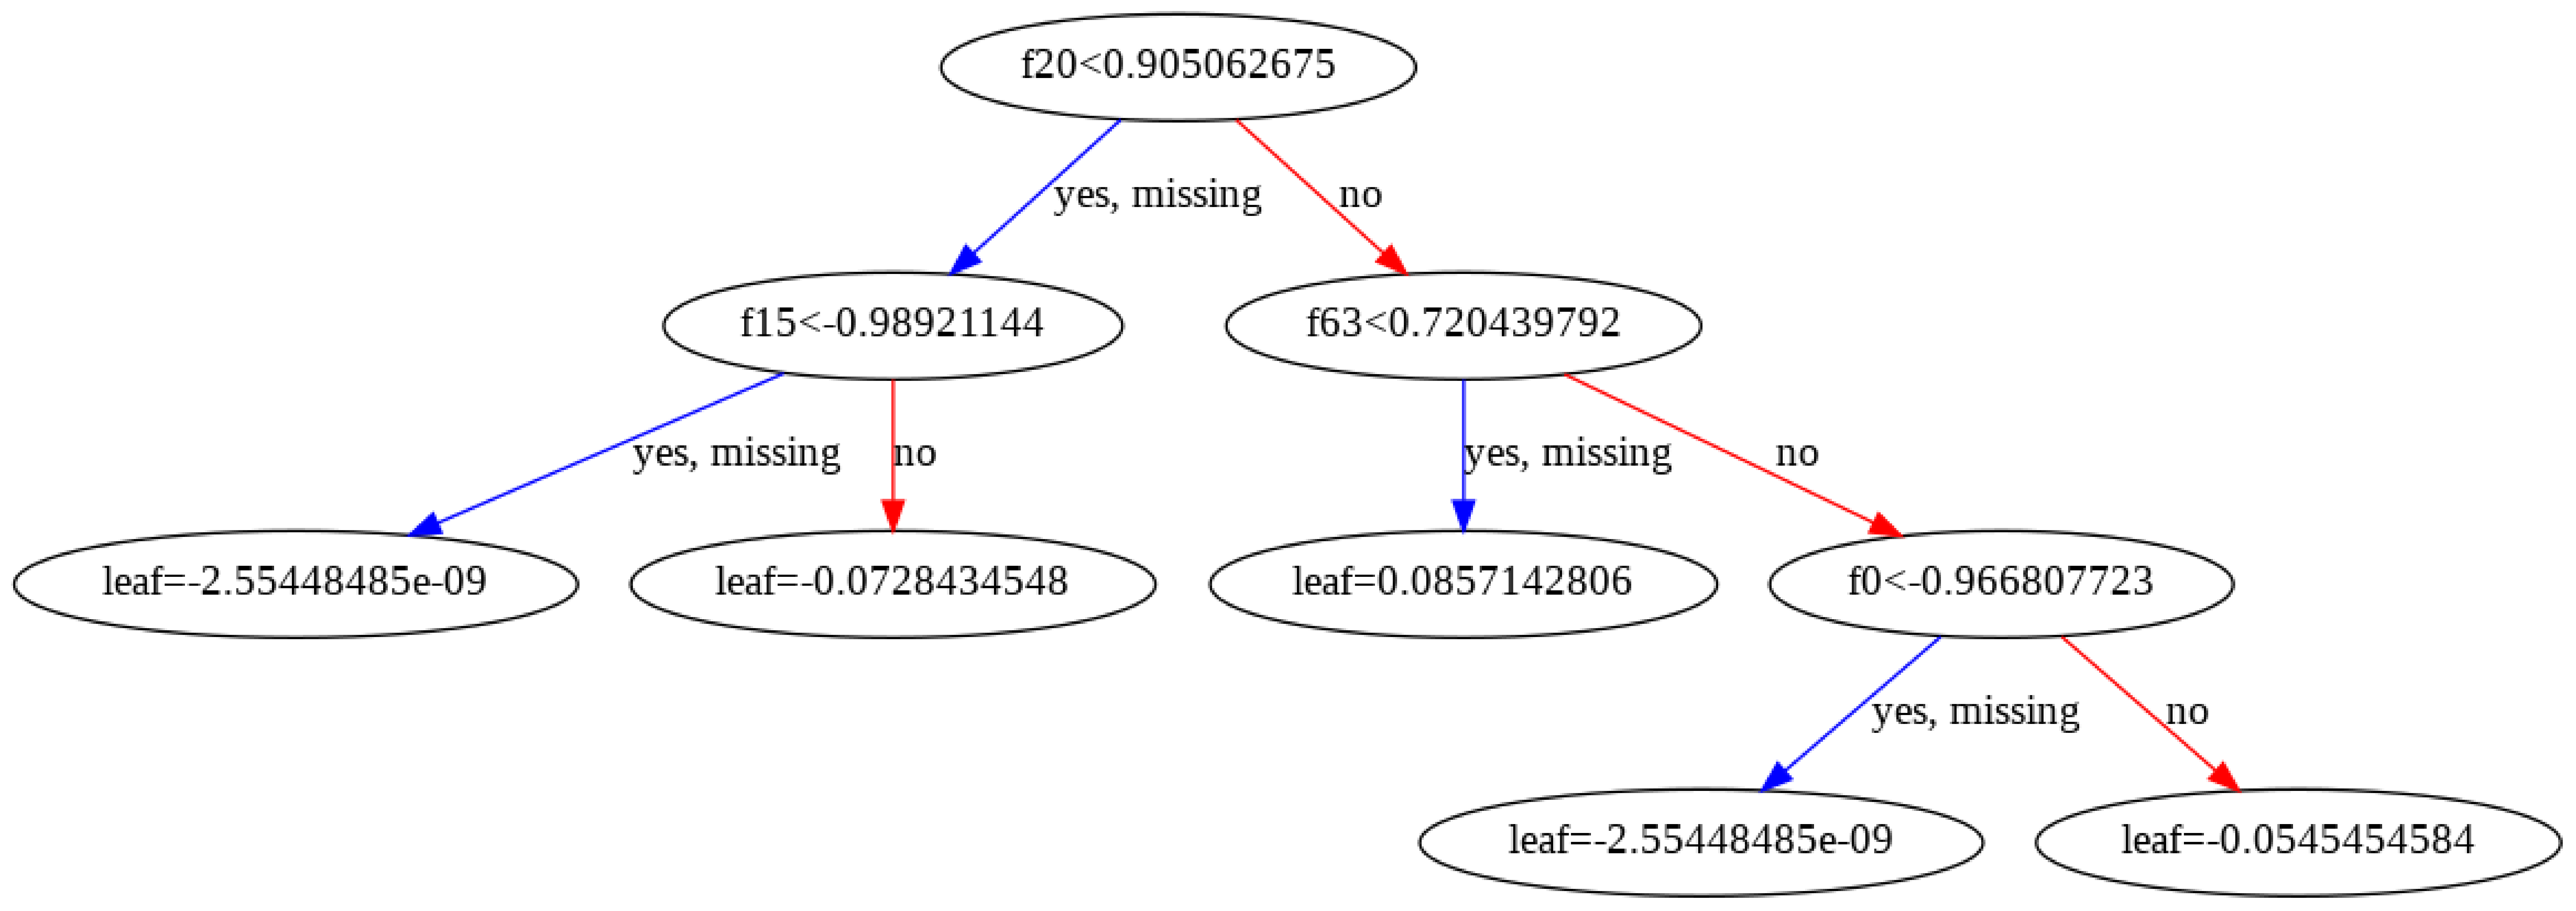

In [310]:
import matplotlib
xgb.plot_tree(xgbc,num_trees=2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

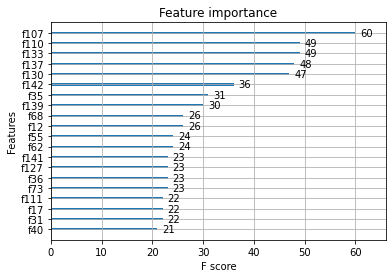

In [323]:
xgb.plot_importance(xgbc, importance_type="weight",max_num_features=20)

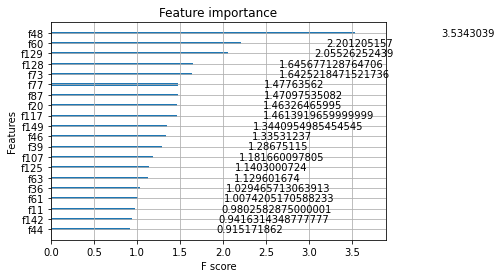

In [324]:
xgb.plot_importance(xgbc, importance_type="gain",max_num_features=20)

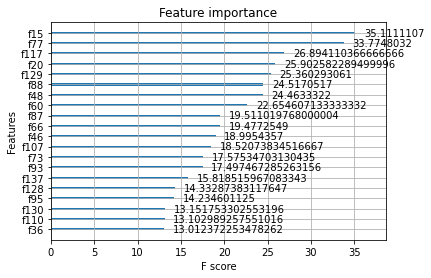

In [325]:
xgb.plot_importance(xgbc, importance_type="cover",max_num_features=20)